In [3]:
import os

def change_dir_in_hipergator():
    # this env var is set on hipergator (SLURM is the job scheduler there)
    if os.getenv("SLURM_JOB_ID", None):
        target_dir = "diff_fam_social_memory_ephys"
        current = os.getcwd()

        while True:
            parent = os.path.dirname(current)
            # If we've reached the root directory without finding the target
            if parent == current:
                raise FileNotFoundError(f"Could not find parent directory '{target_dir}'")

            # Check if the target directory is the current parent's name
            if os.path.basename(parent) == target_dir:
                os.chdir(parent)
                return parent

            current = parent

# Usage
try:
    new_path = change_dir_in_hipergator()
    print(f"Successfully changed to directory: {new_path}")
except FileNotFoundError as e:
    print(e)

Successfully changed to directory: None


In [1]:
import pandas as pd
import numpy as np
import lfp.lfp_analysis.LFP_collection as LFP_collection
import lfp.lfp_analysis.LFP_analysis as lfpa
import pickle
import matplotlib.pyplot as plt
from scipy import stats
from matplotlib import cm
from matplotlib.ticker import ScalarFormatter
import lfp.lfp_analysis.LFP_analysis as lfpa
from itertools import combinations, permutations
from matplotlib.colors import LinearSegmentedColormap
import seaborn as sns
from importlib import reload
from lfp.lfp_analysis.LFP_collection import LFPCollection
import math
from scipy import stats
import lfp.lfp_analysis.preprocessor as preprocessor
import lfp.lfp_analysis.connectivity_wrapper as connect
from scipy.interpolate import interp1d
from importlib import reload

MEDIAN_ZSCORE_MULTIPLIER = 0.6745

def pickle_this(thing_to_pickle, file_name):
    """
    Pickles things
    Args (2):
        thing_to_pickle: anything you want to pickle
        file_name: str, filename that ends with .pkl
    Returns:
        none
    """
    with open(file_name, "wb") as file:
        pickle.dump(thing_to_pickle, file)


def unpickle_this(pickle_file):
    """
    Unpickles things
    Args (1):
        file_name: str, pickle filename that already exists and ends with .pkl
    Returns:
        pickled item
    """
    with open(pickle_file, "rb") as file:
        return pickle.load(file)
    


object_control_lfp_json = r"C:\Users\megha\UFL Dropbox\Meghan Cum\Padilla-Coreano Lab\2024\Cum_SocialMemEphys_pilot2\Object_Control (phase 7)\lfp_data\lfp_collection.json"

object_collection = LFP_collection.LFPCollection.load_collection(object_control_lfp_json)





# test_rec = object_collection.lfp_recordings[0]
# object_collection.brain_region_dict = test_rec.brain_region_dict

c:\Users\megha\anaconda3\envs\ephys_env\lib\site-packages\pandas\core\computation\expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.7.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
c:\Users\megha\anaconda3\envs\ephys_env\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


bidict({'mPFC': 0, 'NAc': 1, 'MD': 2, 'BLA': 3, 'vHPC': 4})

In [65]:
def __get_events__(recording, event, power, event_len, pre_window, post_window, average = True):
    try:
        events = recording.event_dict[event]
    except KeyError:
        print(f"{event} not in event dictionary. Please check spelling")
    all_events = []
    pre_window = math.ceil(pre_window * 1000)
    post_window = math.ceil(post_window * 1000)
    freq_timebin = recording.timestep * 1000
    if event_len is not None:
        event_len_ms = event_len * 1000
    whole_recording = power
    for i in range(events.shape[0]):
        if event_len is not None:
            pre_event = math.ceil((events[i][0] - pre_window) / freq_timebin)
            post_event = math.ceil((events[i][0] + post_window + event_len_ms) / freq_timebin)
        if event_len is None:
            pre_event = math.ceil((events[i][0] - pre_window) / freq_timebin)
            post_event = math.ceil((events[i][1] + post_window) / freq_timebin)
        if post_event < whole_recording.shape[0]:
            # whole_recording = [t, f, b]  for power
            # whole_recording = [t,f,b,b] for coherence + granger
            event_snippet = whole_recording[pre_event:post_event, ...]
            if average:
                event_snippet = np.nanmean(event_snippet, axis=0)
            all_events.append(event_snippet)
    return all_events



def average_events(
    lfp_collection, events, mode, baseline=None, event_len=None, pre_window=0, post_window=0, plot=False, regions = None, freq_range = None
):

    event_averages_dict = {}
    recordings = [lfp_collection]
    for i in range(len(events)):
        recording_averages = []
        for recording in recordings:
            event_averages = __get_events__(recording, events[i], mode, event_len, pre_window, post_window, average = True)
            if baseline is not None:
                adj_averages = __baseline_diff__(
                    recording, event_averages, baseline[i], mode, event_len, pre_window=0, post_window=0, average = True
                )
                recording_averages = recording_averages + adj_averages
            else:
                recording_averages = recording_averages + event_averages
        # recording_averages = [trials, b, f] or [trials, b, b, f]
        event_averages_dict[events[i]] = recording_averages
    if plot:
        plot_power_averages(lfp_collection, event_averages_dict,  regions, freq_range)
    return event_averages_dict

def plot_power_averages(lfp_collection, event_averages, regions=None, freq_range=None):
    if regions is None:
        regions = list(lfp_collection.brain_region_dict.keys())
    if freq_range is None:
        freq_range = [1, 101]
    
    # Calculate rows and columns for subplots
    n_regions = len(regions)
    n_cols = min(3, n_regions)  # Max 3 columns
    n_rows = (n_regions + n_cols - 1) // n_cols  # Ceiling division
    
    # Create figure with subplots
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(6*n_cols, 5*n_rows))
    
    # Flatten axes array for easier indexing if there are multiple subplots
    if n_regions > 1:
        if n_rows == 1 and n_cols == 1:
            axes = np.array([axes])
        axes = axes.flatten()
    else:
        axes = [axes]
    
    # Hide any unused subplots
    for i in range(n_regions, len(axes)):
        axes[i].set_visible(False)
    
    # Plot each region in its own subplot
    for i, region in enumerate(regions):
        ax = axes[i]
        y_max = 0  # Keep track of maximum y value for consistent scaling
        
        for event, averages in event_averages.items():
            # Get the regional data
            region_index = lfp_collection.brain_region_dict[region]
            
            # Calculate mean and SEM across trials
            event_average = np.nanmean(averages, axis=0)
            event_sem = stats.sem(averages, axis=0, nan_policy="omit")
            
            # Extract data for the selected frequency range and region
            y = event_average[freq_range[0]:freq_range[1], region_index]
            y_sem = event_sem[freq_range[0]:freq_range[1], region_index]
            x = range(freq_range[0], freq_range[1])
            
            # Track maximum value for y-axis scaling
            y_max = max(y_max, np.nanmax(y + y_sem))
            
            # Plot mean and SEM
            (line,) = ax.plot(x, y, label=event)
            ax.fill_between(x, y - y_sem, y + y_sem, alpha=0.2, color=line.get_color())
        
        # Set titles and labels
        ax.set_title(f"{region}", fontsize = 20)
        ax.set_xlabel("Frequency (Hz)")
        ax.set_ylabel("Power")
        
        # Add legend to each subplot
        ax.legend()
    
    # Adjust layout for better spacing
    plt.tight_layout()
    plt.suptitle("Regional Power Averages", fontsize=16)
    plt.subplots_adjust(top=0.93)  
    
def power_averages(
    lfp_collection, events, modes, model, titles=None, baseline=None, event_len=None, pre_window=0, post_window=0, plot=False, regions=None, freq_range=None
):
    """
    Calculates average event measurement (power, coherence, or granger) per recording then
    calculates global averages across all recordings from recording averages (to account for
    differences in event numbers per recording)
    
    Parameters:
    -----------
    lfp_collection : object
        Collection of LFP recordings
    events : list
        List of event names to analyze
    modes : list
        List of power calculation results (can be power, coherence, or granger)
    titles : list, optional
        List of titles for each mode (should be same length as modes)
    baseline : list, optional
        List of baseline events
    event_len : float, optional
        Length of event in seconds
    pre_window : float, optional
        Time before event in seconds
    post_window : float, optional
        Time after event in seconds
    plot : bool, optional
        Whether to plot the results
    regions : list, optional
        List of brain regions to include
    freq_range : list, optional
        Frequency range to plot [min, max]
    
    Returns:
    --------
    dict
        Dictionary of event averages for each event and mode
    """
    if not isinstance(modes, list):
        modes = [modes]
    
    if titles is None:
        titles = [f"Mode {i+1}" for i in range(len(modes))]
    elif not isinstance(titles, list):
        titles = [titles]
    
    if len(titles) != len(modes):
        raise ValueError("Length of titles must match length of modes")
    
    # Dictionary to store results for all modes
    all_event_averages = {}
    
    for mode_idx, mode in enumerate(modes):
        event_averages_dict = {}
        recordings = [lfp_collection]
        
        for i in range(len(events)):
            recording_averages = []
            for recording in recordings:
                event_averages = __get_events__(recording, events[i], mode, event_len, pre_window, post_window, average=True)
                if baseline is not None:
                    adj_averages = __baseline_diff__(
                        recording, event_averages, baseline[i], mode, event_len, pre_window=0, post_window=0, average=True
                    )
                    recording_averages = recording_averages + adj_averages
                else:
                    recording_averages = recording_averages + event_averages
            # recording_averages = [trials, b, f] or [trials, b, b, f]
            event_averages_dict[events[i]] = recording_averages
        
        # Store in the all_event_averages dictionary using the title as the key
        all_event_averages[titles[mode_idx]] = event_averages_dict
    
    if plot:
        if model == "power":
            plot_power_comparison(lfp_collection, all_event_averages, regions, freq_range)
        if model == "coherence":
            plot_coherence_comparison(lfp_collection, all_event_averages, regions, freq_range)  
        if model == "granger":
            plot_granger_comparison(lfp_collection, all_event_averages, regions, freq_range)    
    return all_event_averages

def plot_power_comparison(lfp_collection, all_event_averages, regions=None, freq_range=None):
    """
    Plots comparison of different power calculation methods for each brain region.
    
    Parameters:
    -----------
    lfp_collection : object
        Collection of LFP recordings
    all_event_averages : dict
        Dictionary of dictionaries with event averages for each mode
    regions : list, optional
        List of brain regions to plot
    freq_range : list, optional
        Frequency range to plot [min, max]
    """
    import matplotlib.pyplot as plt
    import numpy as np
    from scipy import stats
    
    if regions is None:
        regions = list(lfp_collection.brain_region_dict.keys())
    if freq_range is None:
        freq_range = [1, 101]
    
    # Get number of power calculation methods (modes)
    n_modes = len(all_event_averages)
    
    # Get the events (assuming all modes have the same events)
    first_mode_key = list(all_event_averages.keys())[0]
    events = list(all_event_averages[first_mode_key].keys())
    
    # Create figure with subplots - One row per region, one column per mode
    fig, axes = plt.subplots(len(regions), n_modes, figsize=(12, 8))
    
    # For each brain region (rows)
    for region_idx, region in enumerate(regions):
        region_index = lfp_collection.brain_region_dict[region]
        
        # Find global max y-value for consistent scaling across all plots in this row
        y_max = 0
        for mode_title, event_averages_dict in all_event_averages.items():
            for event, averages in event_averages_dict.items():
                event_average = np.nanmean(averages, axis=0)
                event_sem = stats.sem(averages, axis=0, nan_policy="omit")
                try:
                    y = event_average[freq_range[0]:freq_range[1], region_index]
                    y_sem = event_sem[freq_range[0]:freq_range[1], region_index]
                    y_max = max(y_max, np.nanmax(y + y_sem))
                except IndexError:
                    pass
        # For each power calculation method (columns)
        for mode_idx, (mode_title, event_averages_dict) in enumerate(all_event_averages.items()):
            ax = axes[region_idx, mode_idx]
            
            # Plot each event for this mode and region
            for event, averages in event_averages_dict.items():
                # Calculate mean and SEM across trials
                event_average = np.nanmean(averages, axis=0)
                event_sem = stats.sem(averages, axis=0, nan_policy="omit")
                try:
                # Extract data for the selected frequency range and region
                    y = event_average[freq_range[0]:freq_range[1], region_index]
                    y_sem = event_sem[freq_range[0]:freq_range[1], region_index]
                    x = range(freq_range[0], freq_range[1])

                    # Plot mean and SEM
                    (line,) = ax.plot(x, y, label=event)
                    ax.fill_between(x, y - y_sem, y + y_sem, alpha=0.2, color=line.get_color())
                except IndexError:
                    print(f'No events of type {event}') 
            # Set titles and labels
            if region_idx == 0:
                ax.set_title(mode_title)
            if mode_idx == 0:
                ax.set_ylabel(f"{region}\nPower")
            if region_idx == len(regions) - 1:
                ax.set_xlabel("Frequency (Hz)")
            if mode_idx == n_modes - 1: 
                ax.legend(bbox_to_anchor= (1,1))
            
            # Set y-axis limit to be consistent for this region
            ax.set_ylim(0, y_max * 1.1)
            
            # Add legend to each subplot
           
    
    # Adjust layout for better spacing
    plt.tight_layout()
    plt.suptitle("Power Comparison Across Calculation Methods by Brain Region", fontsize=16)
    plt.subplots_adjust(top=0.93)
    plt.show()
    
def process_data_with_threshold(rec, threshold, time_window):
    """
    Process recording data with the given threshold and time window.
    Returns processed data for further analysis or plotting.
    """
    scaled_traces = preprocessor.scale_voltage(rec.traces, voltage_scaling_value=rec.voltage_scaling)
    time_window_hz = time_window*1000
    total_time = scaled_traces.shape[0]
    n_regions = scaled_traces.shape[1]
    n_chunks = total_time // time_window_hz
    usable_length = n_chunks * time_window_hz
    trimmed_traces = scaled_traces[:usable_length]
    reshaped_traces = trimmed_traces.reshape(n_chunks, time_window_hz, n_regions)
    
    # Process data
    zscore_traces = zscore_chunks(reshaped_traces)
    thresholded_traces = preprocessor.filter(zscore_traces, reshaped_traces, threshold)
    interpolated_traces = zscore_filter(zscore_traces, reshaped_traces, threshold)
    
    # Flatten for analysis and plotting
    flattened_thresholded = thresholded_traces.reshape(usable_length, n_regions)
    flattened_interpolated = interpolated_traces.reshape(usable_length, n_regions)
    flattened_interpolated = fill_missing(flattened_interpolated)
    flattened_zscores = zscore_traces.reshape(usable_length, n_regions)
    
    # Calculate RMS
    rms_traces = preprocessor.root_mean_square(flattened_thresholded)
    interpolated_rms = preprocessor.root_mean_square(flattened_interpolated)
    
    # Return all processed data
    return {
        'original_traces': scaled_traces[:usable_length],
        'zscore_traces': flattened_zscores,
        'thresholded_traces': flattened_thresholded,
        'interpolated_traces': flattened_interpolated,
        'rms_traces': rms_traces,
        'interpolated_rms': interpolated_rms,
        'usable_length': usable_length
    }

def plot_threshold_analysis(processed_data):
    # Plot thresholded data
    plot_zscore(
        processed_data['original_traces'], 
        processed_data['zscore_traces'], 
        processed_data['thresholded_traces'],
        processed_data['interpolated_traces']
        
    )

    return (processed_data['original_traces'], processed_data['interpolated_rms'])

def plot_to_find_threshold(rec, threshold, time_window):
    processed_data = process_data_with_threshold(rec, threshold, time_window)
    return plot_threshold_analysis(processed_data)

def find_and_plot_nan_snippets(processed_data, region_idx=0, window_size=1000, max_snippets=3):

    # Get data for the specified region
    original = processed_data['original_traces'][:, region_idx]
    thresholded = processed_data['thresholded_traces'][:, region_idx]
    interpolated = processed_data['interpolated_traces'][:, region_idx]
    
    # Find indices with NaNs
    nan_indices = np.where(np.isnan(thresholded))[0]
    
    if len(nan_indices) == 0:
        print(f"No NaNs found in region {region_idx}")
        return
    
    # Find start positions for snippets
    snippet_starts = []
    current_start = nan_indices[0] - window_size//4  # Start before NaNs
    
    # Ensure start is within bounds
    current_start = max(0, current_start)
    snippet_starts.append(current_start)
    
    # Find additional snippets if needed
    for idx in nan_indices:
        # Check if we're already far enough from the last snippet start
        if all(abs(idx - start) > window_size for start in snippet_starts):
            new_start = max(0, idx - window_size//4)
            snippet_starts.append(new_start)
            
        # Stop when we have enough snippets
        if len(snippet_starts) >= max_snippets:
            break
    
    # Plot each snippet
    for i, start in enumerate(snippet_starts):
        end = min(start + window_size, len(original))
        
        fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(6, 4))
        
        # Time axis in milliseconds
        time_axis = np.arange(start, end)
        
        # Original trace
        ax1.plot(time_axis, original[start:end], 'b-')
        ax1.set_title(f"Snippet {i+1}: Original Signal (Region {region_idx})")
        ax1.set_ylabel("Amplitude")
        
        # Thresholded trace with NaNs
        ax2.plot(time_axis, thresholded[start:end], 'r-')
        ax2.set_title("Thresholded Signal (NaNs visible as gaps)")
        ax2.set_ylabel("Amplitude")
        
        # Interpolated trace
        ax3.plot(time_axis, interpolated[start:end], 'g-')
        ax3.set_title("Interpolated Signal")
        ax3.set_ylabel("Amplitude")
        ax3.set_xlabel("Time (samples)")
        
        # Add a legend to the last axis
        ax3.legend(['Interpolated', 'Original'], loc='upper right')
        
        # Show count of NaNs in this window
        nan_count = np.isnan(thresholded[start:end]).sum()
        fig.suptitle(f"Signal snippet with {nan_count} NaNs", fontsize=16)
        
        # Align y-axis limits for better comparison
        y_min = min(ax1.get_ylim()[0], ax2.get_ylim()[0], ax3.get_ylim()[0])
        y_max = max(ax1.get_ylim()[1], ax2.get_ylim()[1], ax3.get_ylim()[1])
        for ax in [ax1, ax2, ax3]:
            ax.set_ylim(y_min, y_max)
        
        plt.tight_layout()
        plt.subplots_adjust(top=0.9)
        plt.show()

def zscore_chunks(reshaped_traces):
    medians = np.median(reshaped_traces, axis=1, keepdims=True)
    
    # Calculate MAD for each chunk and region
    # First, get absolute deviations from median
    abs_deviations = np.abs(reshaped_traces - medians)
    # Then get median of those absolute deviations
    mads = np.median(abs_deviations, axis=1, keepdims=True)
    # Avoid division by zero
    mads = np.maximum(mads, np.finfo(float).eps)
    
    # Calculate z-scores
    temp_traces = reshaped_traces - medians
    zscore_traces = MEDIAN_ZSCORE_MULTIPLIER * temp_traces / mads
    return zscore_traces

def zscore(traces):
    mads = median_abs_dev(traces)
    # traces = [time, channels]
    temp_traces = traces - np.median(traces, axis=0)
    zscore_traces = MEDIAN_ZSCORE_MULTIPLIER * temp_traces / mads
    return zscore_traces

def zscore_filter(zscore, voltage_scaled, threshold):
    mask = np.abs(zscore) < threshold
    nan_array =  np.where(mask, voltage_scaled, np.nan)
    # neg_mask = zscore < -threshold
   
    return nan_array

def plot_zscore(processed_traces, zscore_traces, thresholded_zscore_traces, interpolated_traces, file_path=None):
    fig, axes = plt.subplots(2, 2, figsize=(12, 4))
    ax1 = axes[0, 0]
    ax2 = axes[0, 1]
    ax3 = axes[1, 0]
    ax4 = axes[1, 1]

    ax1.plot(processed_traces[:, 0])
    ax1.set_title("Scaled traces")
    ax1.set_ylabel("Amplitude")

    ax2.plot(zscore_traces[:, 0])
    ax2.set_title("Z-scored Signal")
    ax2.set_ylabel("Z-score")
    ax2.set_xlabel("Time")

    ax3.plot(thresholded_zscore_traces[:, 0])
    ax3.set_title("Filtered Scaled")
    ax3.set_ylabel("Ampltude")
    
    ax4.plot(interpolated_traces[:, 0])
    ax4.set_title("Interpolated Traces")
    ax4.set_ylabel("Ampltude")

    plt.tight_layout()
  
    plt.show()
    return

def plot_all_regions(processed_traces, brain_region_dict):
    fig, axes = plt.subplots(2, 2, figsize=(12, 4))
    ax1 = axes[0, 0]
    ax2 = axes[0, 1]
    ax3 = axes[1, 0]
    ax4 = axes[1, 1]

    ax1.plot(processed_traces[:, 1])
    ax1.set_title(f"{brain_region_dict.inverse[1]}")
    ax1.set_ylabel("Amplitude")
    
    ax2.plot(processed_traces[:, 2])
    ax2.set_title(f"{brain_region_dict.inverse[2]}")
    ax2.set_ylabel("Amplitude")
    
    ax3.plot(processed_traces[:, 3])
    ax3.set_title(f"{brain_region_dict.inverse[3]}")
    ax3.set_ylabel("Amplitude")

    ax4.plot(processed_traces[:, 4])
    ax4.set_title(f"{brain_region_dict.inverse[4]}")
    ax4.set_ylabel("Amplitude")
    
    plt.show()
    
def fill_missing(Y, kind="cubic"):
    Y_filled = Y.copy()
    print(Y.shape)
    # Return early if no NaNs
    if not np.isnan(Y).any():
        return Y
    
    # Interpolate across time for each region
    for i in range(Y.shape[1]):
        
        y = Y_filled[:, i]
        
        # Skip if no NaNs or all NaNs in this region
        if not np.isnan(y).any() or np.isnan(y).all():
            continue
        
        # Find indices of non-NaN values
        valid_indices = np.flatnonzero(~np.isnan(y))
        # Find indices of NaN values
        nan_indices = np.flatnonzero(np.isnan(y))
        # Build interpolant if we have valid points
        if len(valid_indices) > 1:  # Need at least 2 points for interpolation
            # Create interpolation function
            f = interp1d(
                valid_indices, 
                y[valid_indices], 
                kind=kind, 
                fill_value="extrapolate",
                bounds_error=False
            )
            
            # Apply interpolation to missing values
            y[nan_indices] = f(nan_indices)
        elif len(valid_indices) == 1:
            # If only one valid point, fill with that value
            y[nan_indices] = y[valid_indices[0]]
        
        # Check if we still have NaNs (possible at edges depending on interpolation method)
        if np.isnan(y).any():
            # Use nearest-value approach for any remaining NaNs
            mask = np.isnan(y)
            idx = np.flatnonzero(~mask)
            if len(idx) > 0:
                y[mask] = np.interp(
                    np.flatnonzero(mask),
                    idx,
                    y[idx]
                )
        
        # Save the interpolated region
        Y_filled[:, i] = y
    
    return Y_filled

def plot_nan_analysis(recording, powers, titles, rms_traces, window_size=10):
    import numpy as np
    import matplotlib.pyplot as plt
    
    if not isinstance(powers, list):
        powers = [powers]
    
    if not isinstance(titles, list):
        titles = [titles]
    
    if len(titles) != len(powers):
        raise ValueError("Number of titles must match number of power calculations")
    
    n_powers = len(powers)
    
    # Create figure with 3 rows (one for each plot type) and n_powers columns
    fig, axes = plt.subplots(3, n_powers, figsize=(3*n_powers, 7))
    
    # Handle the case where there's only one power calculation
    if n_powers == 1:
        axes = axes.reshape(3, 1)
    
    # Calculate RMS traces NaN data once (common to all power calcs)
    # Convert to minutes
    
    # For each power calculation
    for p_idx, (power, title) in enumerate(zip(powers, titles)):
        total_nans = []
        nan_percentages = []
        total_rms_nans = np.isnan(rms_traces[p_idx][:,0])
        cum_sum_rms = np.cumsum(total_rms_nans)
        x_rms = np.array(range(rms_traces[p_idx].shape[0]))/1000/60
        
        # Time axis for power data
        x = np.array(range(power.shape[0]))
        x_power = x/60/2  # Convert to minutes
        
        # Calculate NaN statistics
        for t in range(power.shape[0]):
            total_nans.append(np.isnan(power[t,:,0]).sum())
            try:
                window_total_nans = np.isnan(power[t-window_size:t,1,0]).sum()
                nan_percentages.append((window_total_nans/window_size)*100)
            except IndexError:
                nan_percentages.append(0)
        
        cum_nans = np.cumsum(total_nans)
        
        # Row 1: Cumulative NaNs in Power
        axes[0, p_idx].scatter(x_power, cum_nans)
        axes[0, p_idx].set_ylabel('No. of NaNs')
        axes[0, p_idx].set_xlabel('Time (min)')
        axes[0, p_idx].set_title(f'{recording.name}\n{title}\nCumulative NaNs')
        
        # Row 2: NaN Percentage in Power
        axes[1, p_idx].plot(x_power, nan_percentages, 'r-')
        axes[1, p_idx].set_ylabel('% NaNs in last 10s')
        axes[1, p_idx].set_xlabel('Time (min)')
        axes[1, p_idx].set_title(f'{recording.name}\n{title}\n% NaNs (10s Window)')
        axes[1, p_idx].set_ylim(0, 100)
        
        # Row 3: RMS Traces NaNs (same for all power calcs, but included for completeness)
        axes[2, p_idx].scatter(x_rms, cum_sum_rms)
        axes[2, p_idx].set_ylabel('No. of NaNs')
        axes[2, p_idx].set_xlabel('Time (min)')
        axes[2, p_idx].set_title(f'{recording.name}\nRMS Traces Cumulative NaNs')
    
    # Adjust layout to prevent overlap
    plt.tight_layout()
    plt.show()

In [66]:
def nan_analysis(recording, threshold, window_size=10):
    """
    Plots NaN analysis for multiple power calculations side by side.
    
    Parameters:
    -----------
    recording : object
        Recording object containing name attribute
    powers : list
        List of power calculation arrays, each with shape [time, channels, frequencies]
    titles : list
        List of titles for each power calculation (same length as powers)
    rms_traces : array
        RMS traces array with shape [time, channels]
    window_size : int, optional
        Window size for calculating percentage of NaNs, default is 10
        
    Returns:
    --------
    fig : matplotlib figure
        The figure object containing all plots
    """

    
    # Create figure with 3 rows (one for each plot type) and n_powers columns
    
    
    # Calculate RMS traces NaN data once (common to all power calcs)
    # Convert to minutes
    rms_traces = recording.rms_traces
    if hasattr(recording, 'power'):
        power = recording.power
    else: 
        power = connectivity_wrapper.calculate_power(rms_traces,
                                                     recording.resample_rate,
                                                     recording.halfbandwidth,
                                                     recording.timewindow,
                                                     recording.timestep)
    if hasattr(recording, 'coherence'):
        coherence = recording.coherence
    else:
        coherence = connectivity_wrapper.calculate_coherence(rms_traces,
                                                     recording.resample_rate,
                                                     recording.halfbandwidth,
                                                     recording.timewindow,
                                                     recording.timestep)
    if hasattr(recording, 'grangers'):
        grangers = recording.grangers
        datasets = [rms_traces, power, coherence, grangers]
        dataset_names = ['RMS Traces', 'Power', 'Coherence', 'Grangers']
        percent_nans_overall = []
        
    # For each power calculation
    else:
        datasets = [rms_traces, power, coherence]
        dataset_names = ['RMS Traces', 'Power', 'Coherence']
        percent_nans_overall = []
    fig, axes = plt.subplots(len(datasets), 2, figsize=(12, 10))
    # Process each dataset (RMS traces, power, coherence)
    for row_idx, (data, name) in enumerate(zip(datasets, dataset_names)):
        # Calculate time axes
        if row_idx == 0:  # RMS traces
            # Convert sample indices to minutes for RMS traces
            x_data = np.array(range(data.shape[0])) / recording.resample_rate / 60
            # For RMS data, check NaNs across all channels
            total_nans = np.sum(np.isnan(data), axis=1)
        else:  # Power or coherence
            # Convert to minutes for power/coherence
            x_data = np.array(range(data.shape[0])) / (recording.resample_rate/recording.timestep) / 60
            # For power/coherence data, check NaNs across all channels and frequencies
            if name == 'Power':
                total_nans = np.sum(np.isnan(data), axis=(1,2))
            if (name == 'Coherence') | (name == 'Granger'):
                modified_data = data.copy()
                for i in range(data.shape[2]):  # Loop through regions
                    modified_data[:, :, i, i] = 0 
                total_nans = np.sum(np.isnan(modified_data), axis=(1,2,3))

        
        # Calculate cumulative sum of NaNs
        cum_nans = np.cumsum(total_nans)
        # Calculate percentage of NaNs in window
        nan_percentages = []
        for t in range(data.shape[0]):
            if t < window_size:
                if (name == 'Coherence') | (name == 'Grangers'):
                    modified_data = data[:t+1,...].copy()
                    for i in range(data.shape[2]):  # Loop through regions
                        modified_data[:, :, i, i] = 0  # Replace diagonal with zeros
                    
                    window_nans = np.sum(np.isnan(modified_data))
                    
                    # Calculate denominator for Coherence/Granger (excluding diagonal elements)
                    num_regions = data.shape[2]
                    total_region_pairs = num_regions * num_regions - num_regions  # All pairs minus diagonal
                    denominator = (t+1) * data.shape[1] * total_region_pairs

                else:    
                    window_nans = np.sum(np.isnan(data[:t+1]))
                    denominator = (t+1) * (data.shape[1] if row_idx == 0 else data.shape[1] * data.shape[2])
            else:
                window_start = t - window_size + 1
                window_nans = np.sum(np.isnan(data[window_start:t+1]))
                denominator = window_size * (data.shape[1] if row_idx == 0 else data.shape[1] * data.shape[2])
            
            nan_percentages.append((window_nans/denominator)*100)
        
        # Calculate overall percentage of NaNs for bar graph
        total_elements = data.size
        if (name == 'Coherence') | (name == 'Grangers'):
            modified_data = data.copy()
            for i in range(data.shape[2]):  # Loop through regions
                modified_data[:, :, i, i] = 0 
            total_nan_elements = np.isnan(modified_data).sum()
        else:
            total_nan_elements = np.isnan(data).sum()
        percent_nans_overall.append((total_nan_elements/total_elements)*100)
        
        # Column 1: Cumulative NaNs
        axes[row_idx, 0].plot(x_data, cum_nans)
        axes[row_idx, 0].set_ylabel('Number of NaNs')
        axes[row_idx, 0].set_xlabel('Time (minutes)')
        axes[row_idx, 0].set_title(f'{recording.name} - {name} - Cumulative NaNs')
        
        # Column 2: NaN Percentage in window
        axes[row_idx, 1].plot(x_data, nan_percentages, 'r-')
        axes[row_idx, 1].set_ylabel(f'% NaNs in {window_size}s window')
        axes[row_idx, 1].set_xlabel('Time (minutes)')
        axes[row_idx, 1].set_title(f'{recording.name} - {name} - % NaNs ({window_size}s Window)')
        axes[row_idx, 1].set_ylim(0, 100)
    
    plt.tight_layout()
    
    # Create a standalone bar graph for overall NaN percentages
    fig_bar = plt.figure(figsize=(8, 6))
    ax_bar = fig_bar.add_subplot(111)
    
    bars = ax_bar.bar(dataset_names, percent_nans_overall, color=['blue', 'green', 'red'])
    
    # Add value labels on top of each bar
    for bar in bars:
        height = bar.get_height()
        ax_bar.text(bar.get_x() + bar.get_width()/2., height + .2,
                   f'{height:.2f}%', ha='center', va='bottom')
    
    ax_bar.set_ylabel('Percentage of NaNs')
    ax_bar.set_title(f'{recording.name} - Overall NaN Percentages')
    ax_bar.set_ylim(0, max(percent_nans_overall) * 1.15)  # Add some headroom for labels
    
    plt.tight_layout()
    plt.show()

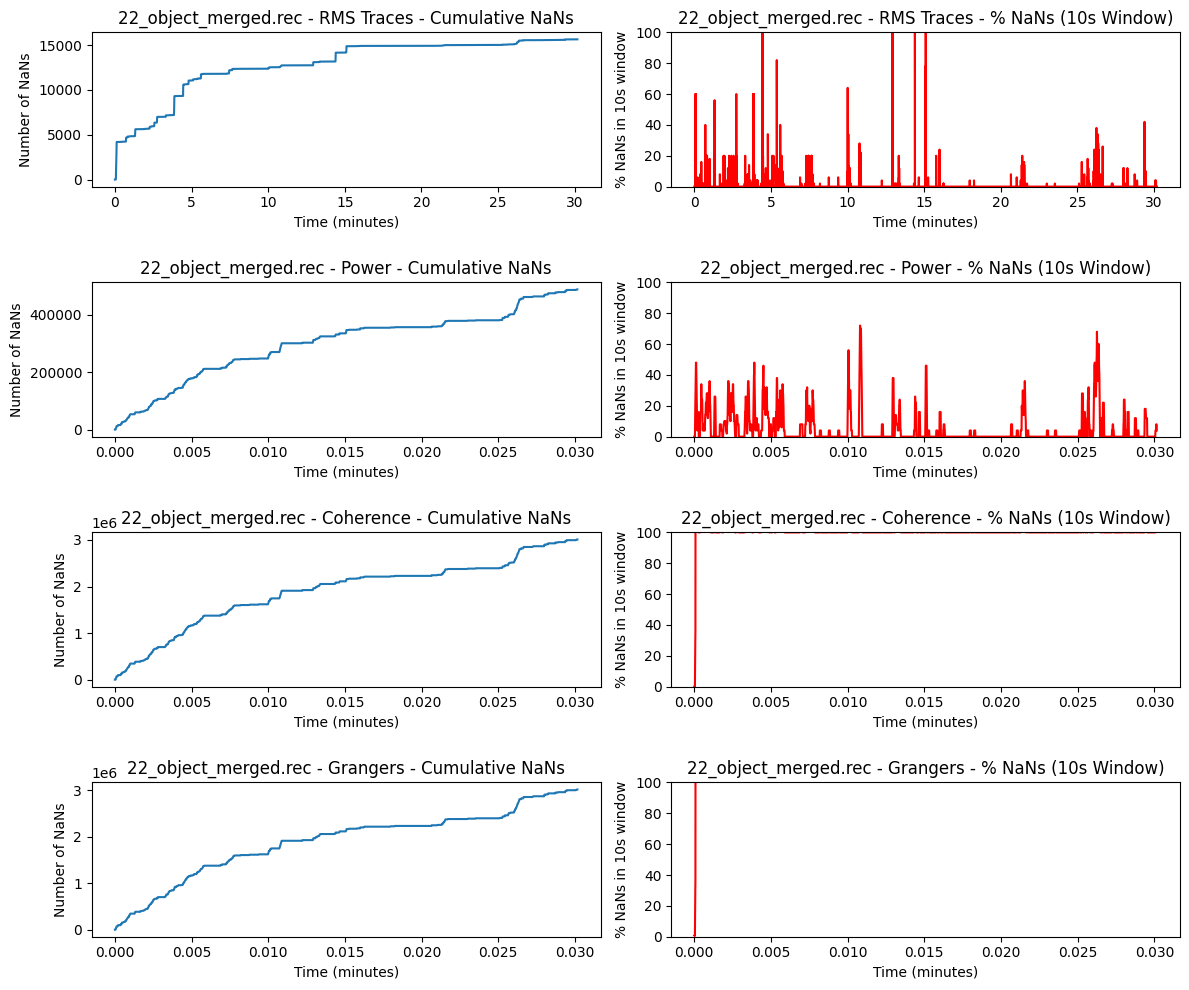

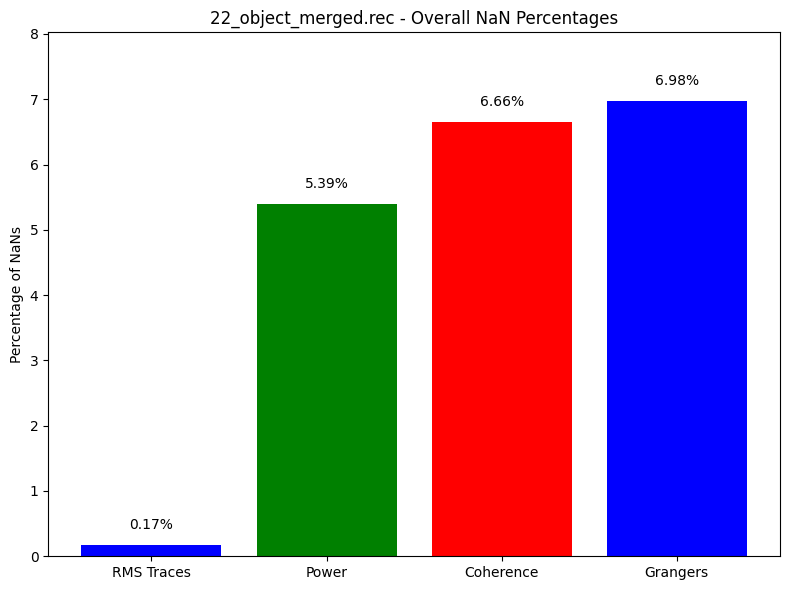

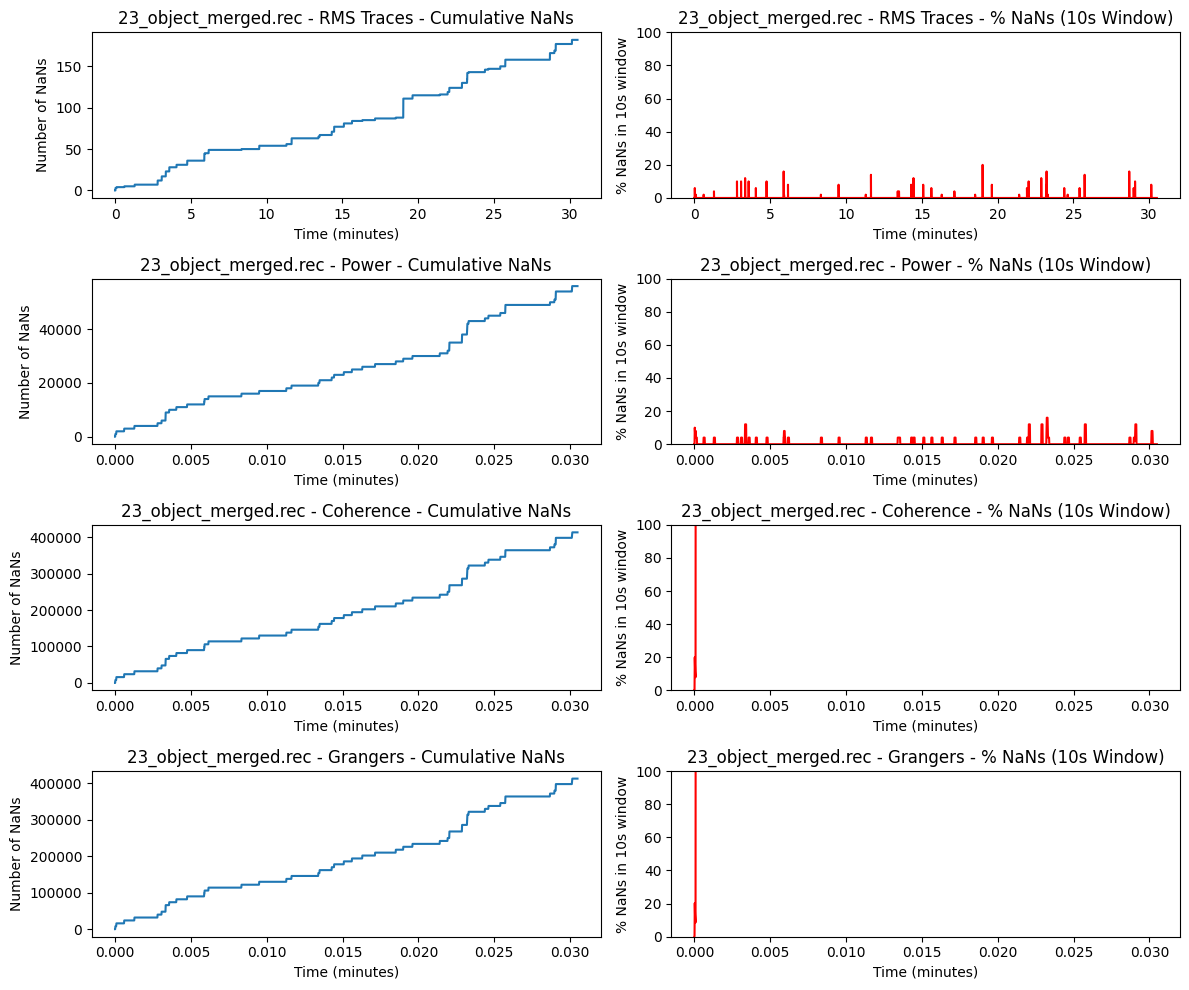

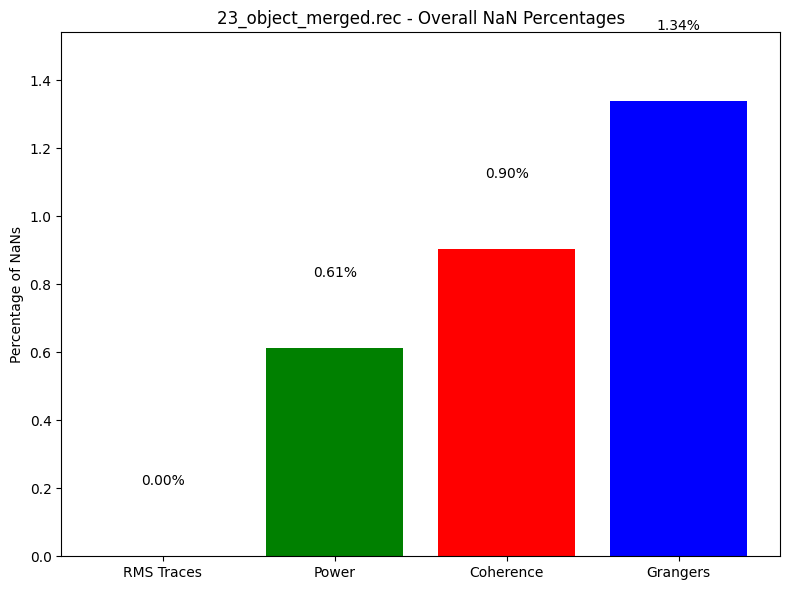

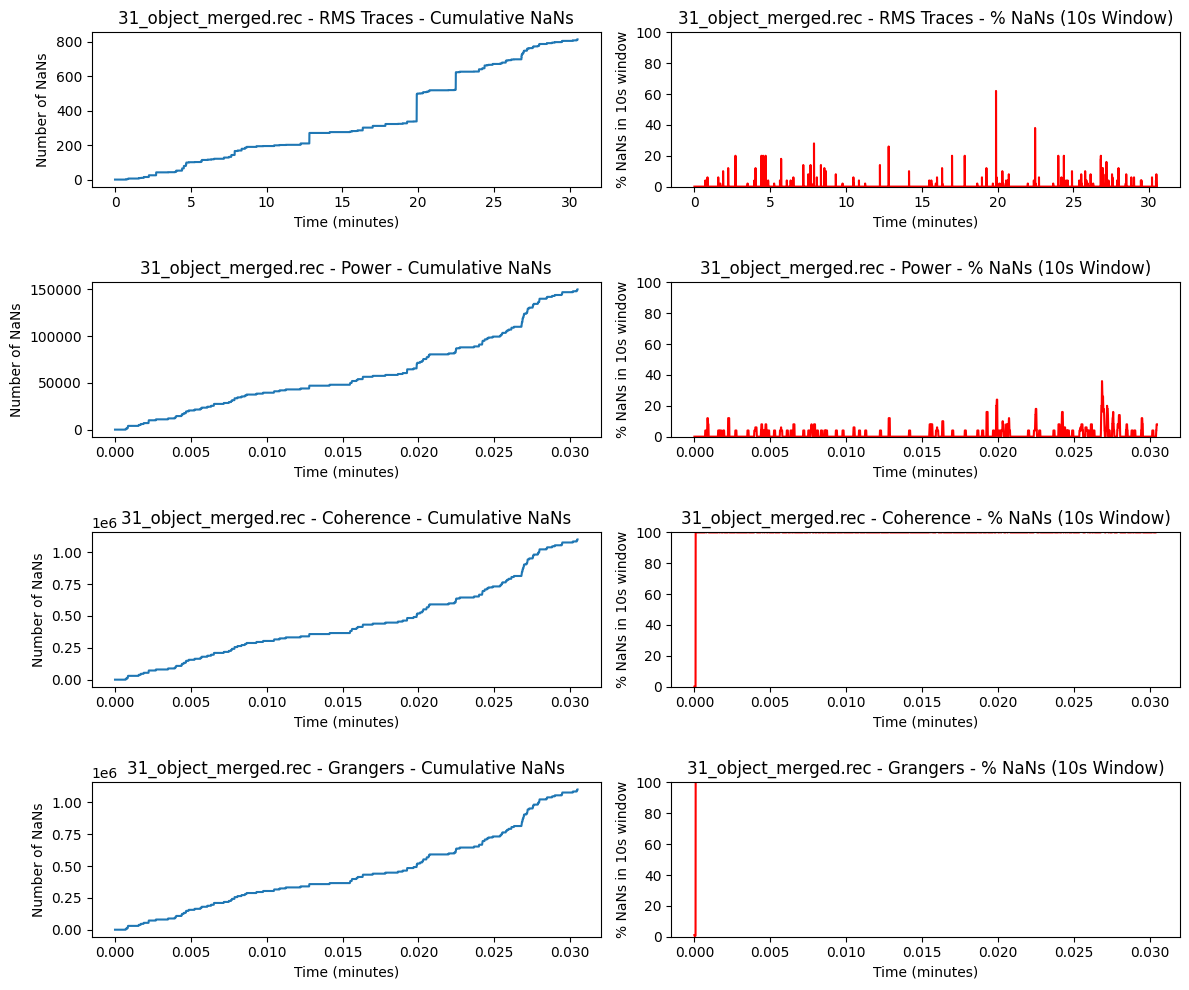

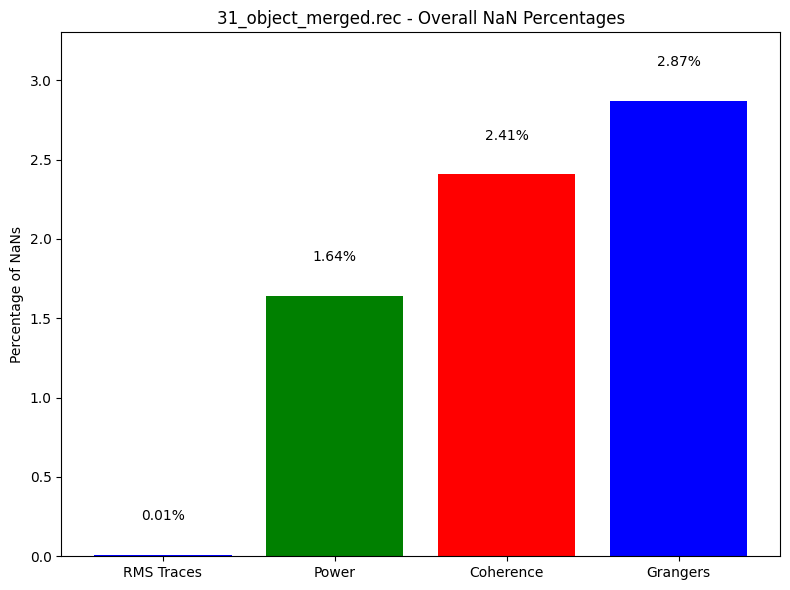

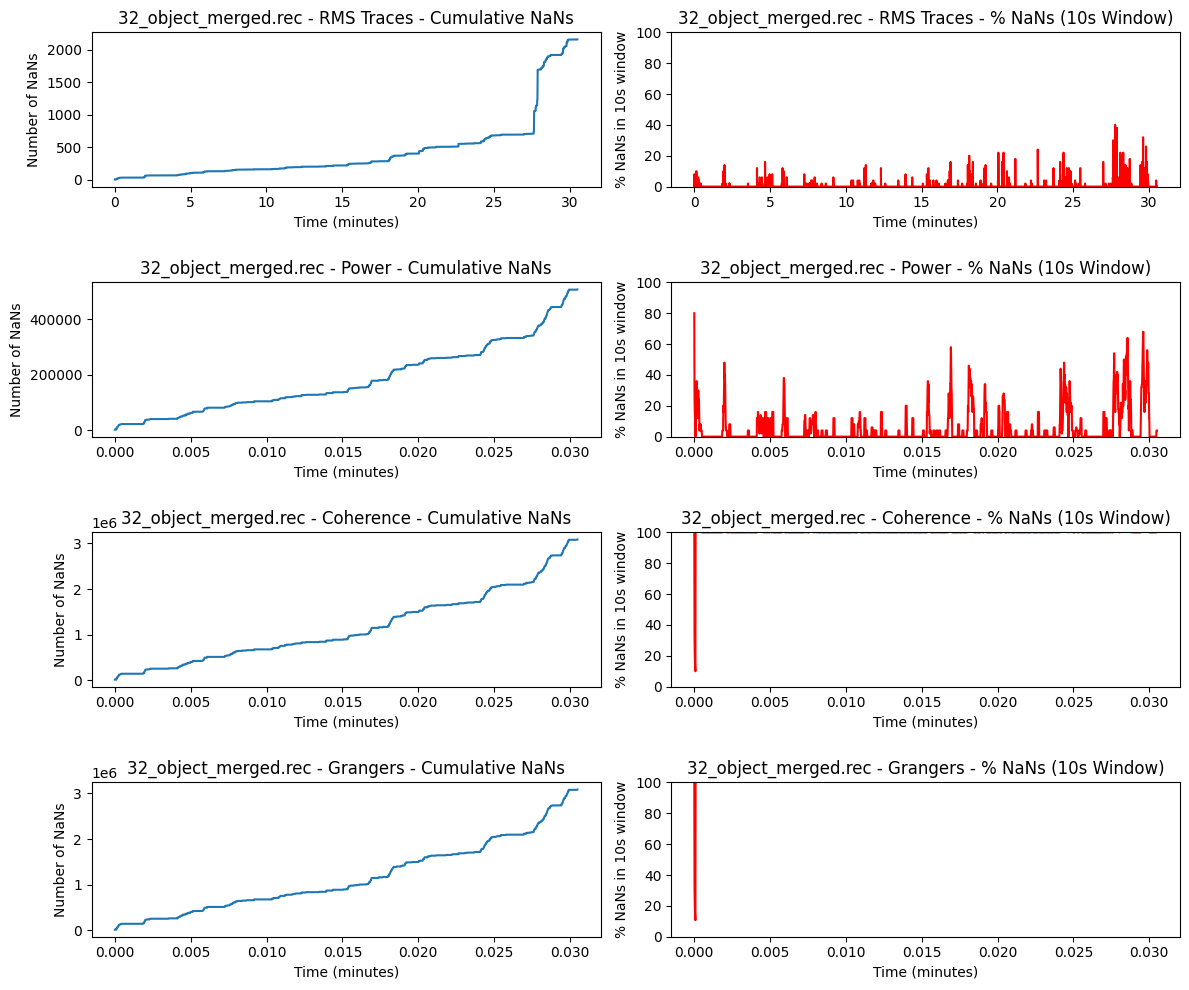

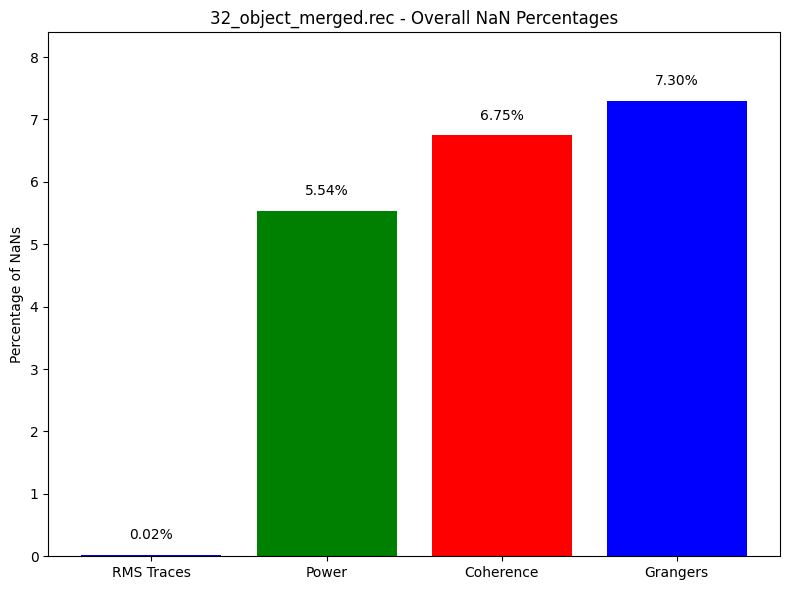

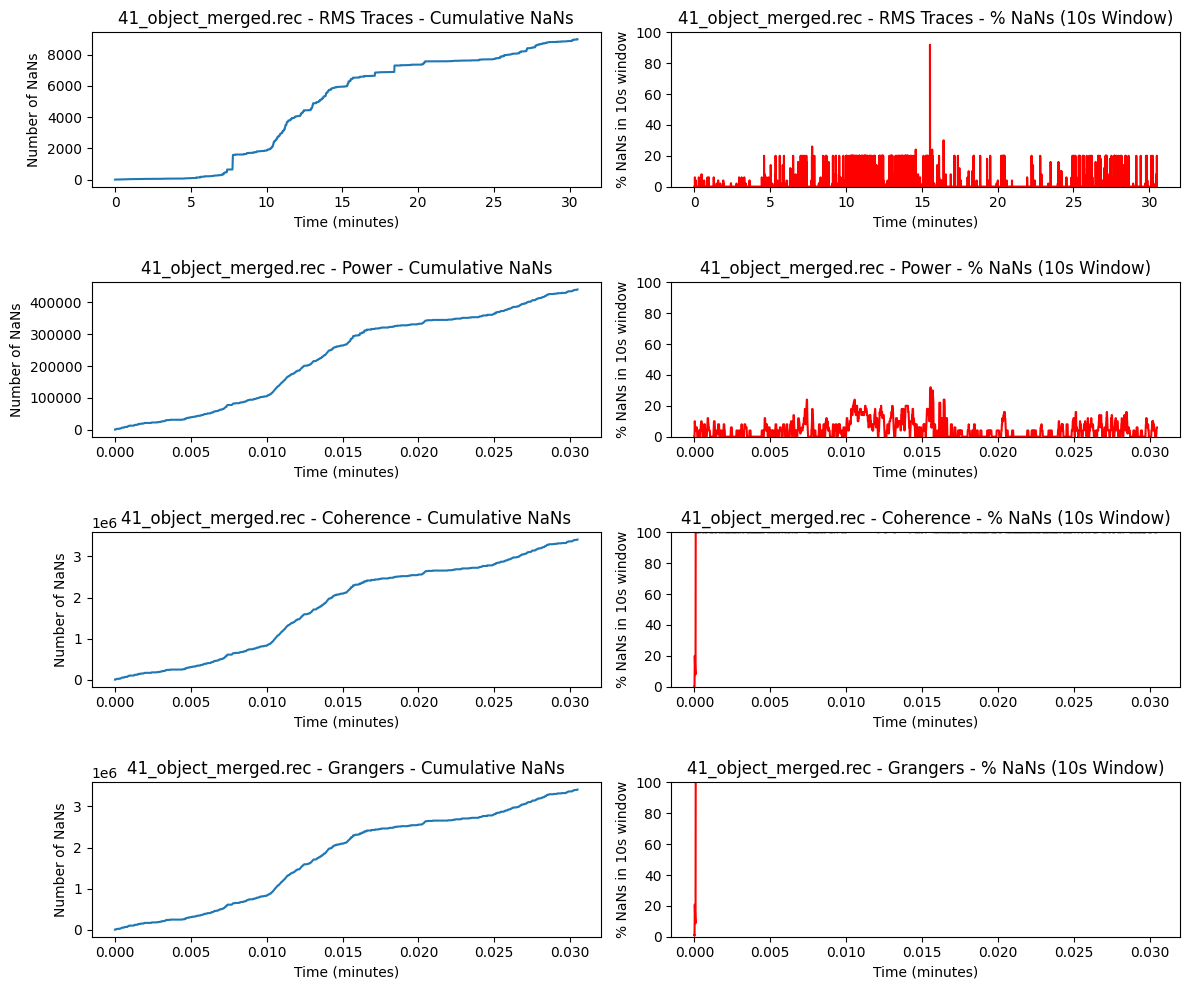

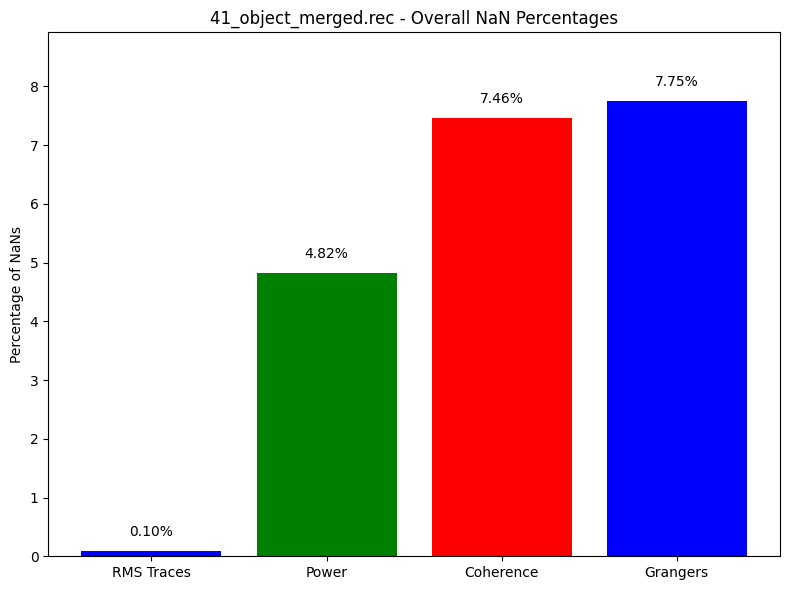

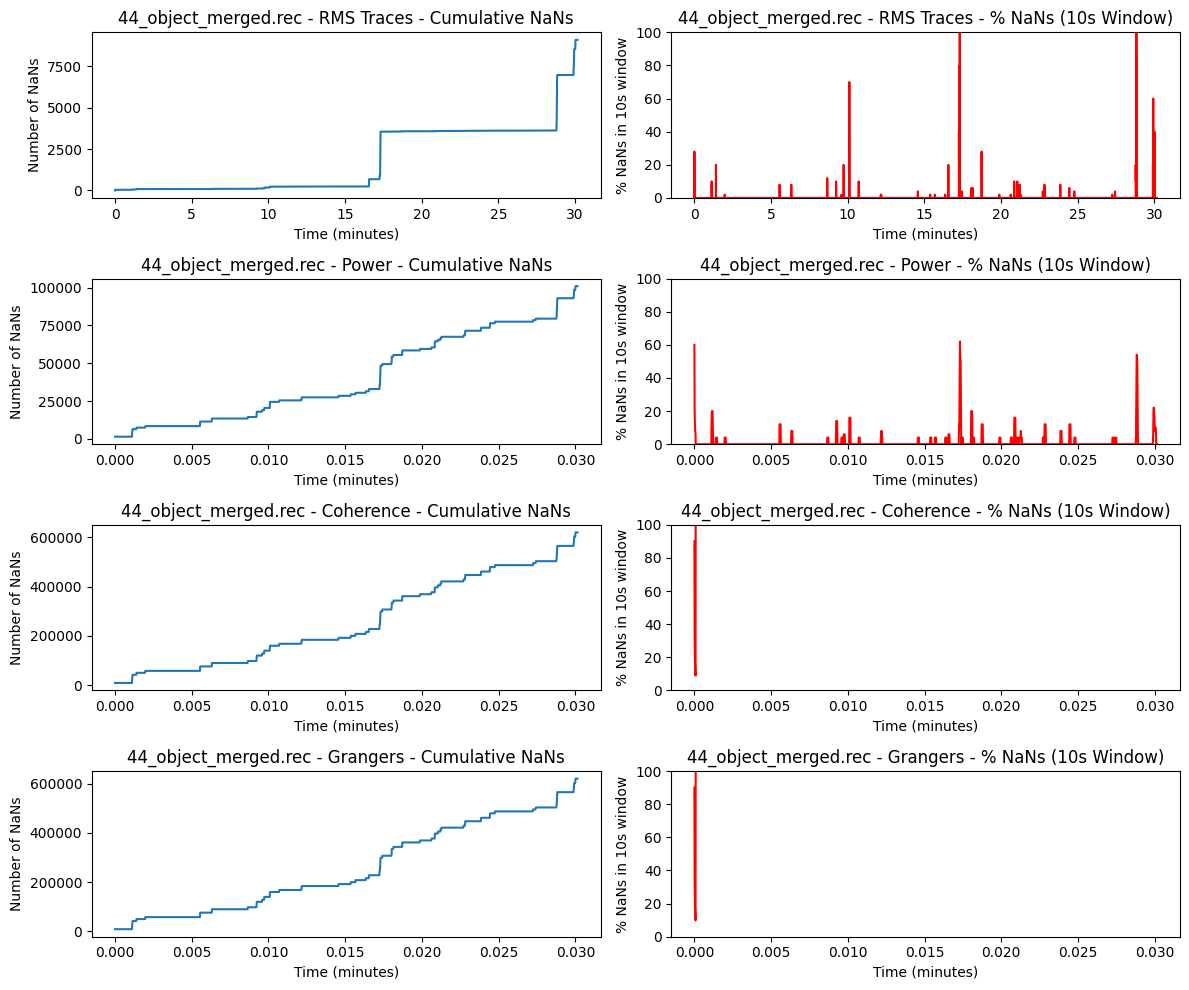

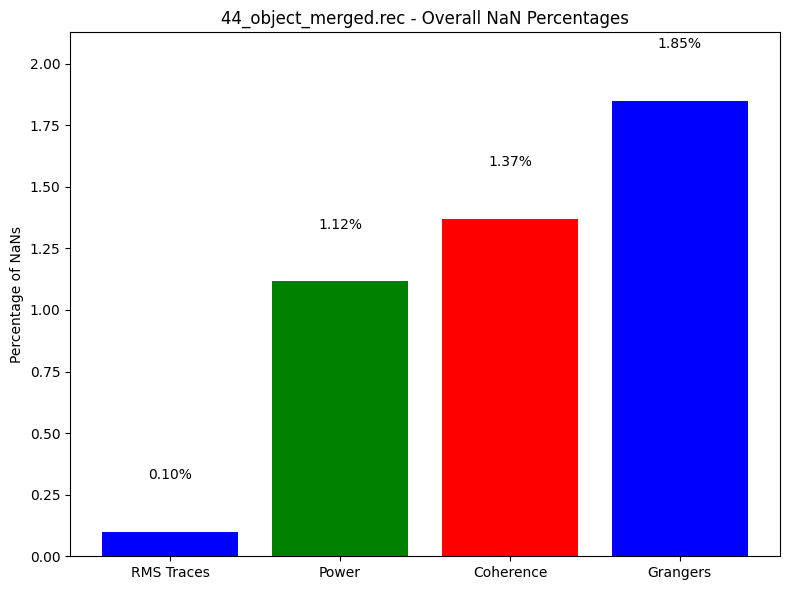

In [67]:
for recording in object_collection.recordings:
    # Set parameters
    threshold = 5
    window_size = 10  # seconds
    
    # Perform NaN analysis
    nan_analysis(recording, threshold, window_size)

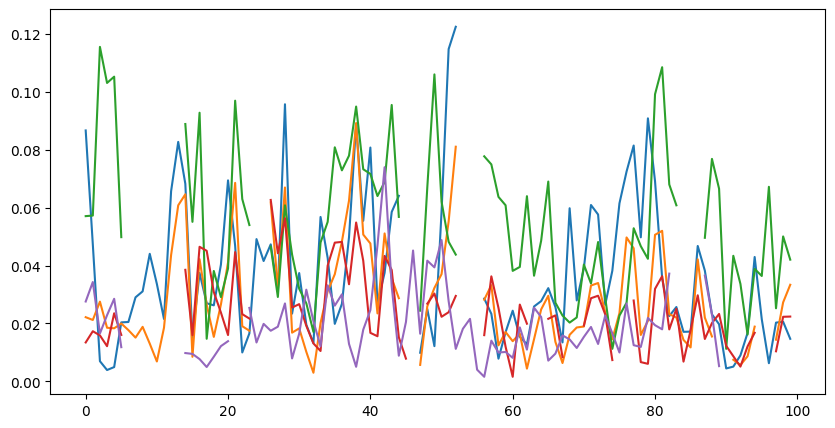

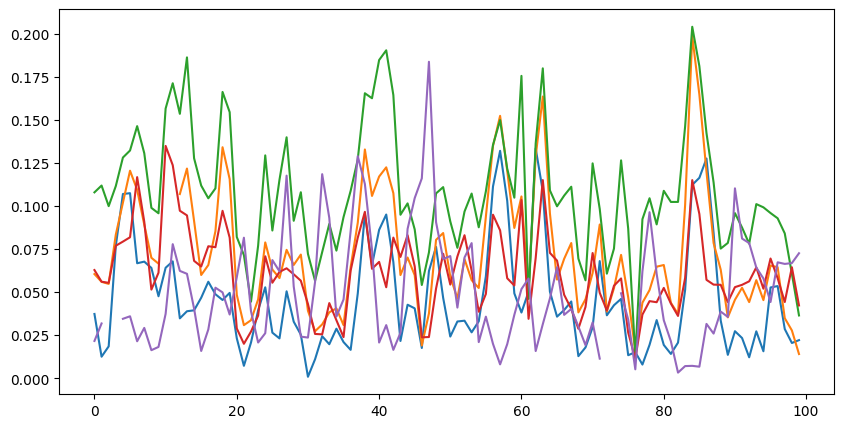

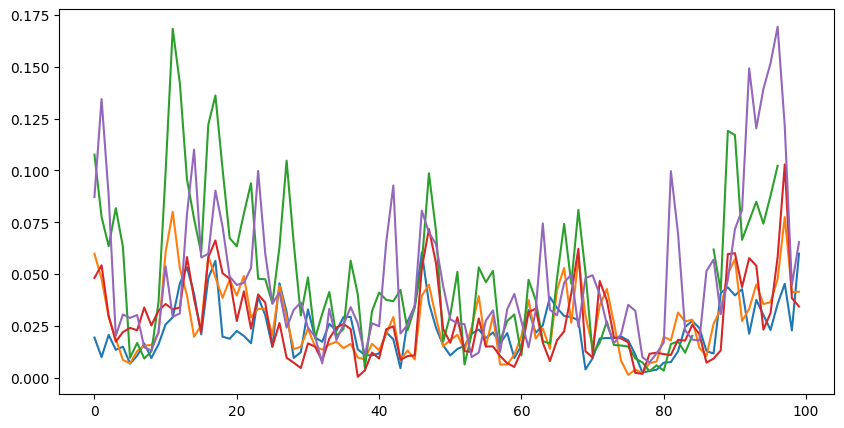

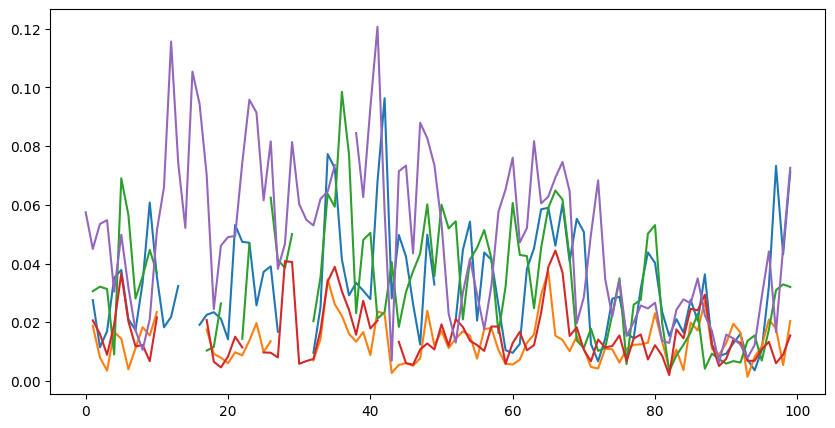

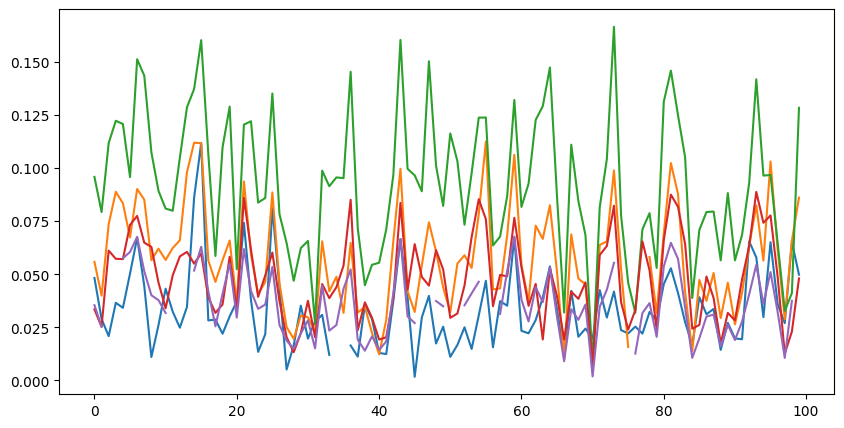

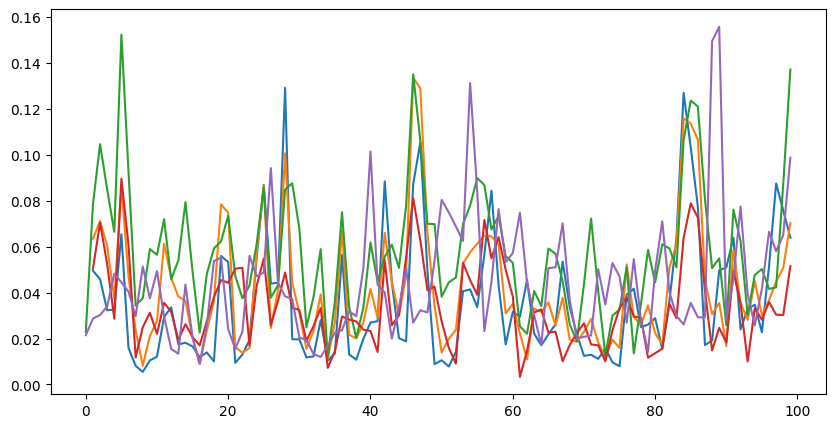

In [68]:
for recording in object_collection.recordings:
    freq = 8
    plt.figure(figsize=(10, 5))
    plt.plot(recording.power[:100, freq, 0], label='BLA power')
    plt.plot(recording.power[:100, freq, 1], label='MD power')
    plt.plot(recording.power[:100, freq, 2], label='mPFC power')
    plt.plot(recording.power[:100, freq, 3], label='NAc power')
    plt.plot(recording.power[:100, freq, 4], label='vHPC power')
    plt.show()

(3620, 500, 5)
(3620, 500, 5)


C:\Users\megha\AppData\Local\Temp\ipykernel_20772\2807042000.py:25: RuntimeWarning: Mean of empty slice
  event_snippet = np.nanmean(event_snippet, axis=0)


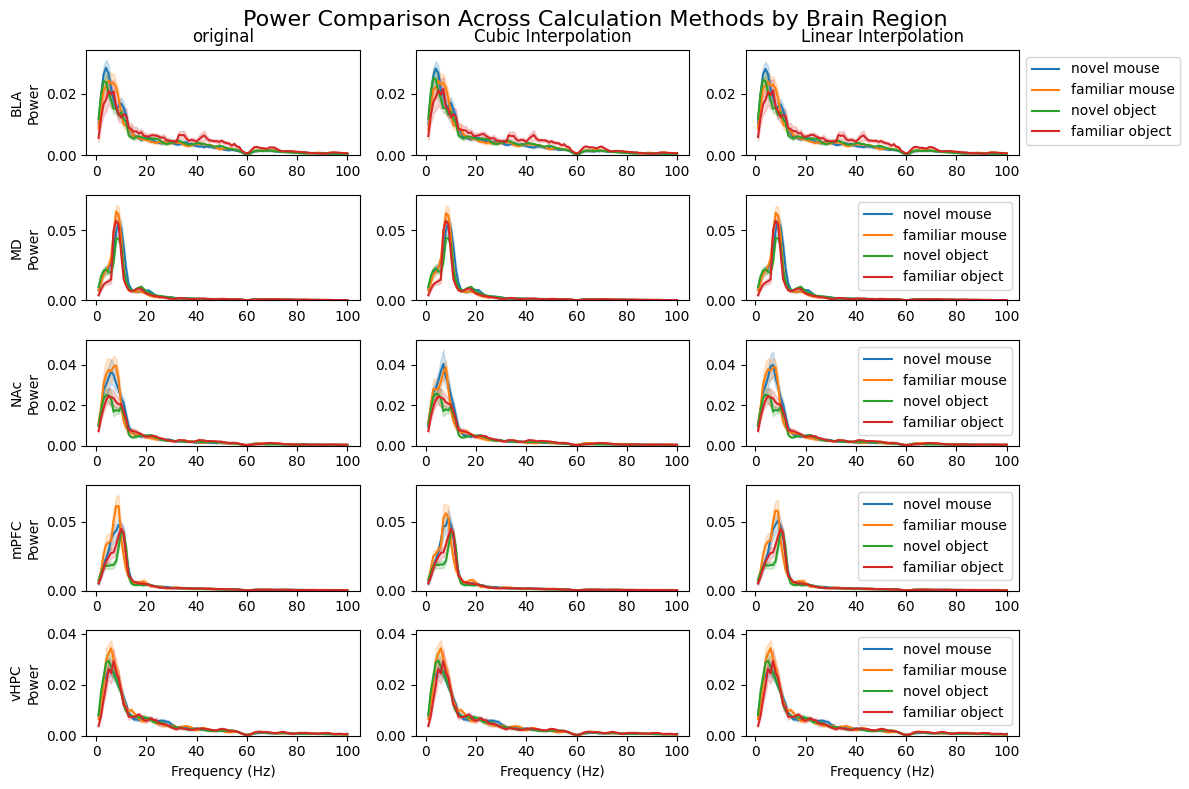

(3660, 500, 5)
(3660, 500, 5)


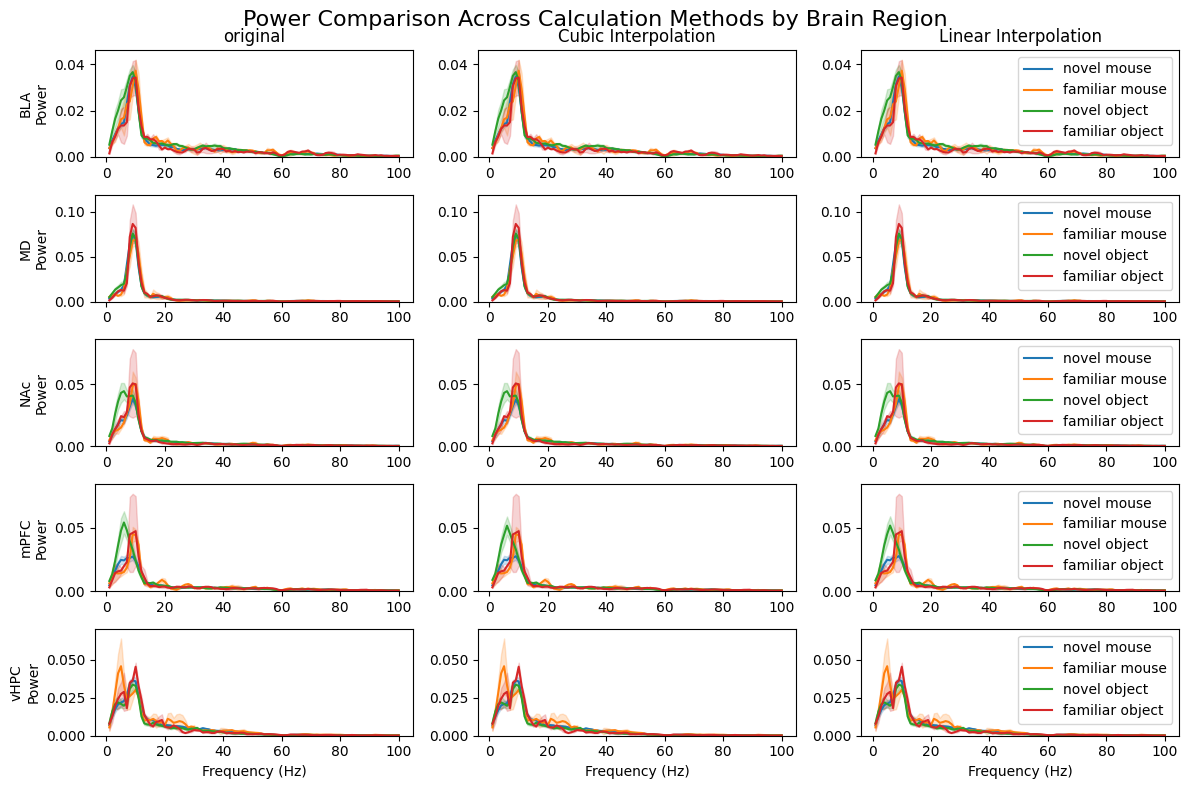

(3659, 500, 5)
(3659, 500, 5)


c:\Users\megha\anaconda3\envs\ephys_env\lib\site-packages\numpy\core\_methods.py:206: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\Users\megha\AppData\Local\Temp\ipykernel_20772\2807042000.py:247: RuntimeWarning: All-NaN slice encountered
  y_max = max(y_max, np.nanmax(y + y_sem))


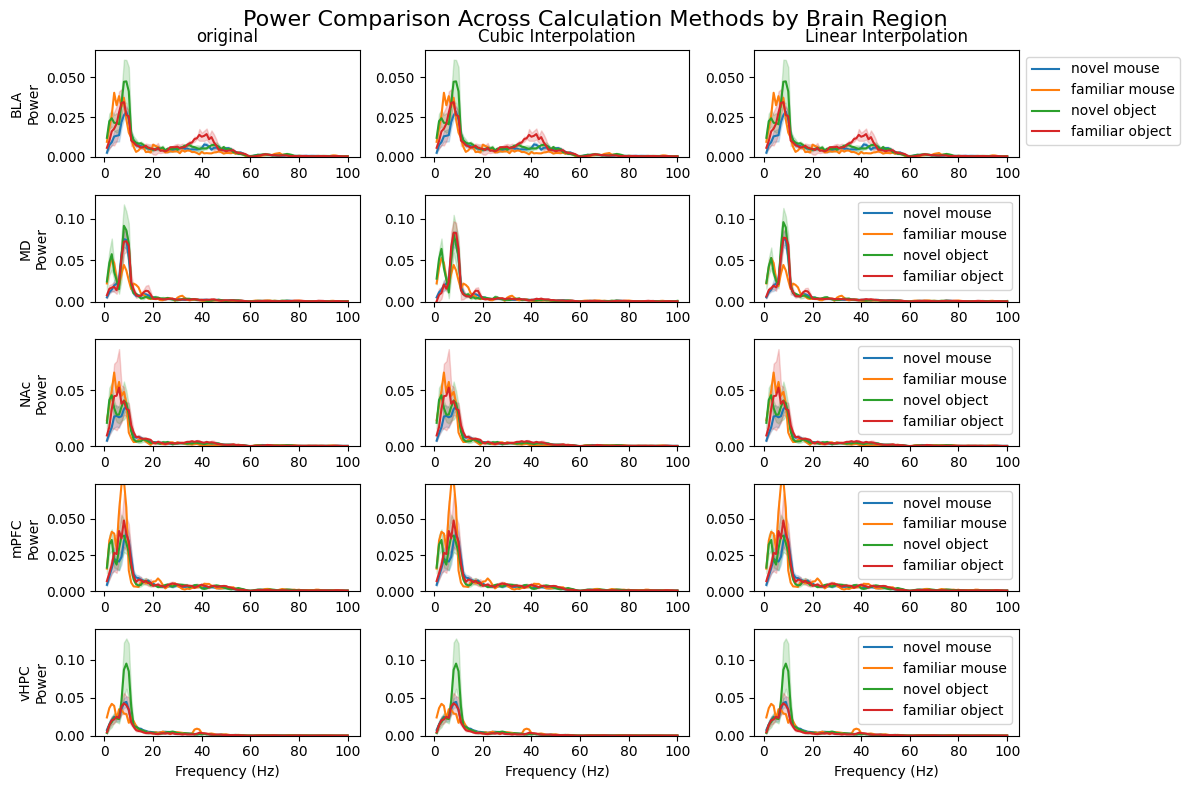

(3660, 500, 5)
(3660, 500, 5)


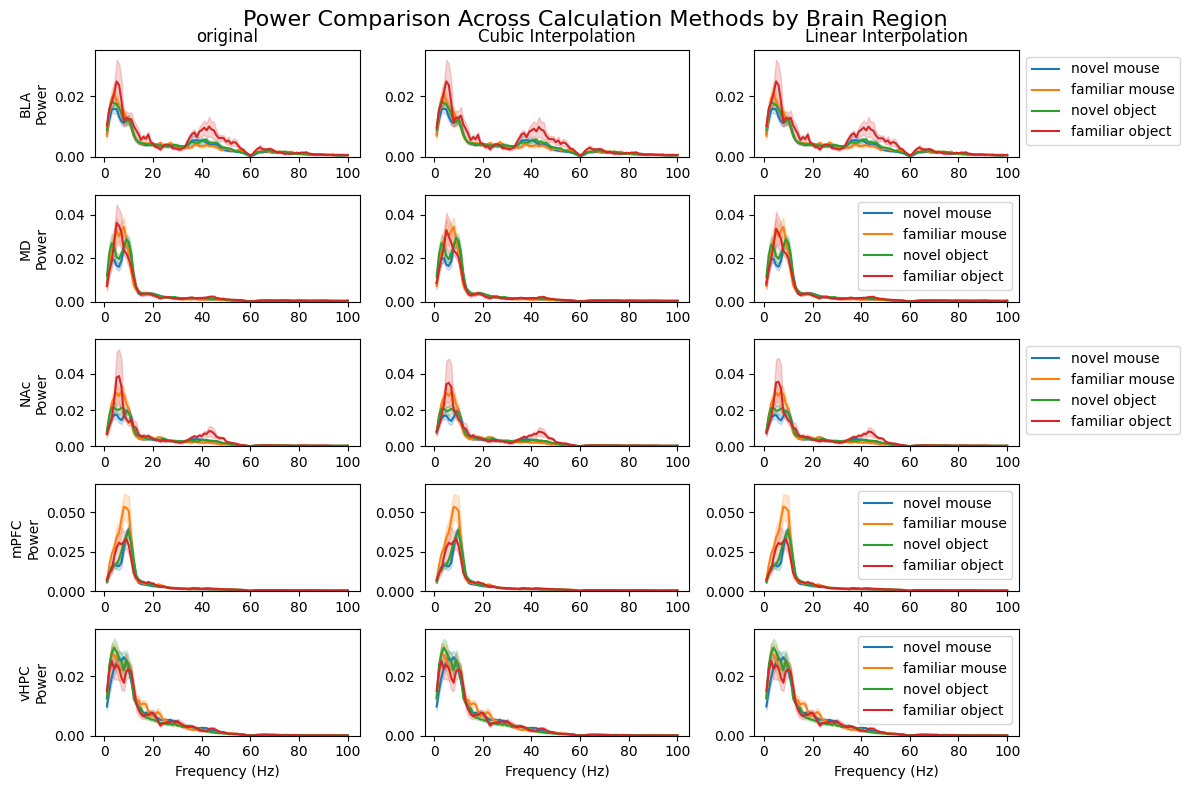

(3659, 500, 5)
(3659, 500, 5)


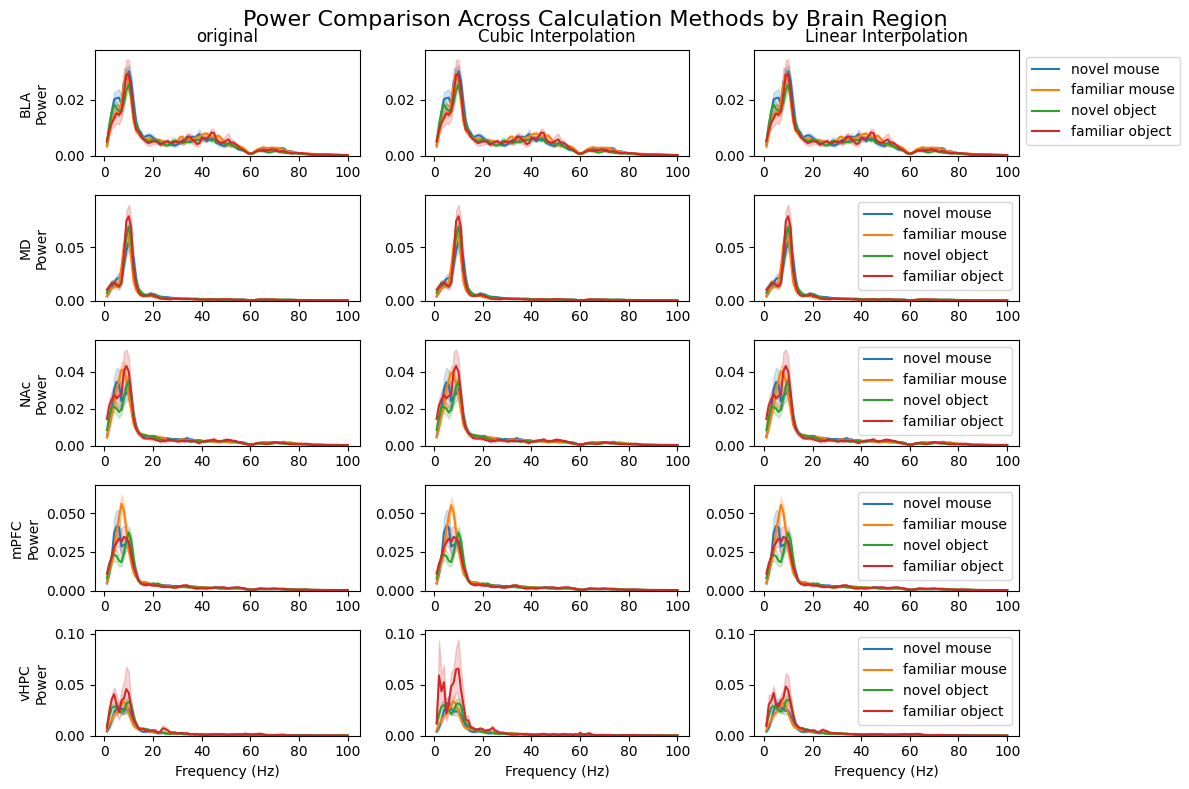

(3618, 500, 5)
(3618, 500, 5)


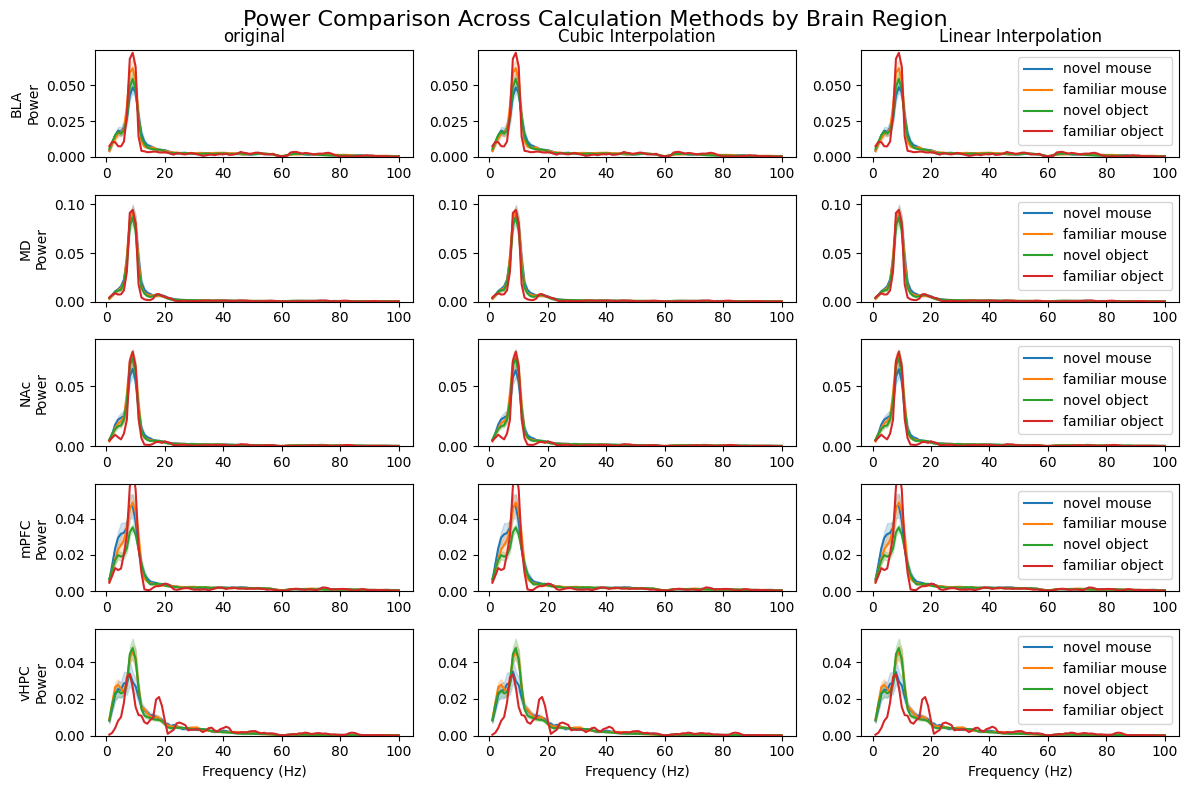

In [ ]:
def fill_missing_power(Y, kind="cubic"):
    Y_filled = Y.copy()
    print(Y.shape)
    # Return early if no NaNs
    if not np.isnan(Y).any():
        return Y
    
    # Interpolate across time and frequencies for each region
    for i in range(Y.shape[1]): #frequency
        for j in range (Y.shape[2]): #region
            y = Y_filled[:, i, j]
            
            # Skip if no NaNs or all NaNs in this region
            if not np.isnan(y).any() or np.isnan(y).all():
                continue
            
            # Find indices of non-NaN values
            valid_indices = np.flatnonzero(~np.isnan(y))
            # Find indices of NaN values
            nan_indices = np.flatnonzero(np.isnan(y))
            # Build interpolant if we have valid points
            if len(valid_indices) > 1:  # Need at least 2 points for interpolation
                # Create interpolation function
                f = interp1d(
                    valid_indices, 
                    y[valid_indices], 
                    kind=kind, 
                    fill_value="extrapolate",
                    bounds_error=False
                )
                
                # Apply interpolation to missing values
                y[nan_indices] = f(nan_indices)
            elif len(valid_indices) == 1:
                # If only one valid point, fill with that value
                y[nan_indices] = y[valid_indices[0]]
            
            # Check if we still have NaNs (possible at edges depending on interpolation method)
            if np.isnan(y).any():
                # Use nearest-value approach for any remaining NaNs
                mask = np.isnan(y)
                idx = np.flatnonzero(~mask)
                if len(idx) > 0:
                    y[mask] = np.interp(
                        np.flatnonzero(mask),
                        idx,
                        y[idx]
                    )
            
            # Save the interpolated region
            Y_filled[:, i, j] = y
        
    return Y_filled

def fill_missing_coherence_granger(Y, kind="cubic"):
    Y_filled = Y.copy()
    print(Y.shape)
    # Return early if no NaNs
    if not np.isnan(Y).any():
        return Y
    
    # Interpolate across time for each region
    for i in range(Y.shape[1]):
        for j in range(Y.shape[2]):
            for k in range(Y.shape[3]):
                if j == k:
                    Y_filled[:, i, j, k] = 0
                else:
                    y = Y_filled[:, i, j, k]
                    
                    # Skip if no NaNs or all NaNs in this region
                    if not np.isnan(y).any() or np.isnan(y).all():
                        continue
                    
                    # Find indices of non-NaN values
                    valid_indices = np.flatnonzero(~np.isnan(y))
                    # Find indices of NaN values
                    nan_indices = np.flatnonzero(np.isnan(y))
                    # Build interpolant if we have valid points
                    if len(valid_indices) > 1:  # Need at least 2 points for interpolation
                        # Create interpolation function
                        f = interp1d(
                            valid_indices, 
                            y[valid_indices], 
                            kind=kind, 
                            fill_value="extrapolate",
                            bounds_error=False
                        )
                        
                        # Apply interpolation to missing values
                        y[nan_indices] = f(nan_indices)
                    elif len(valid_indices) == 1:
                        # If only one valid point, fill with that value
                        y[nan_indices] = y[valid_indices[0]]
                    
                    # Check if we still have NaNs (possible at edges depending on interpolation method)
                    if np.isnan(y).any():
                        # Use nearest-value approach for any remaining NaNs
                        mask = np.isnan(y)
                        idx = np.flatnonzero(~mask)
                        if len(idx) > 0:
                            y[mask] = np.interp(
                                np.flatnonzero(mask),
                                idx,
                                y[idx]
                            )
                    
                    # Save the interpolated region
                    Y_filled[:, i, j, k] = y
    print(Y_filld.shape, 'filled')
    return Y_filled


for recording in object_collection.recordings:
    interpolated_power = fill_missing_power(recording.power, kind="cubic")
    linear_power = fill_missing_power(recording.power, kind="linear")
    power_averages(recording, events = ['novel mouse', 'familiar mouse', 'novel object', 'familiar object'], modes = [recording.power, interpolated_power, linear_power], model = 'power',
                    titles = ['original', 'Cubic Interpolation', 'Linear Interpolation'], plot = True )
    

In [75]:
def plot_coherence_comparison(lfp_collection, all_event_averages, regions=None, freq_range=None):
    """
    Plots comparison of different coherence calculation methods for each brain region pair.
    Only plots the upper triangle of region pairs (i,j) where i < j.
    
    Parameters:
    -----------
    lfp_collection : object
        Collection of LFP recordings
    all_event_averages : dict
        Dictionary of dictionaries with event averages for each mode
    regions : list, optional
        List of brain regions to plot
    freq_range : list, optional
        Frequency range to plot [min, max]
    """
    import matplotlib.pyplot as plt
    import numpy as np
    from scipy import stats
    
    if regions is None:
        regions = list(lfp_collection.brain_region_dict.keys())
    if freq_range is None:
        freq_range = [1, 101]
    
    # Get number of coherence calculation methods (modes)
    n_modes = len(all_event_averages)
    
    # Get the events (assuming all modes have the same events)
    first_mode_key = list(all_event_averages.keys())[0]
    events = list(all_event_averages[first_mode_key].keys())
    
    # Generate all region pairs (upper triangle only)
    region_pairs = []
    for i in range(len(regions)):
        for j in range(i+1, len(regions)):  # Only upper triangle
            region_pairs.append((regions[i], regions[j]))
    
    # Create figure with subplots - One row per region pair, one column per mode
    fig, axes = plt.subplots(len(region_pairs), n_modes, figsize=(12, len(region_pairs)*2))
    if len(region_pairs) == 1:
        axes = axes.reshape(1, -1)
    
    # For each region pair (rows)
    for pair_idx, (region1, region2) in enumerate(region_pairs):
        region1_index = lfp_collection.brain_region_dict[region1]
        region2_index = lfp_collection.brain_region_dict[region2]
        
        # Find global max y-value for consistent scaling across all plots in this row
        y_max = 0
        for mode_title, event_averages_dict in all_event_averages.items():
            for event, averages in event_averages_dict.items():
                event_average = np.nanmean(averages, axis=0)
                event_sem = stats.sem(averages, axis=0, nan_policy="omit")
                try:
                    y = event_average[freq_range[0]:freq_range[1], region1_index, region2_index]
                    y_sem = event_sem[freq_range[0]:freq_range[1], region1_index, region2_index]
                    y_max = max(y_max, np.nanmax(y + y_sem))
                except IndexError:
                    pass
        
        # For each coherence calculation method (columns)
        for mode_idx, (mode_title, event_averages_dict) in enumerate(all_event_averages.items()):
            if len(region_pairs) == 1:
                ax = axes[mode_idx]
            else:
                ax = axes[pair_idx, mode_idx]
            
            # Plot each event for this mode and region pair
            for event, averages in event_averages_dict.items():
                # Calculate mean and SEM across trials
                event_average = np.nanmean(averages, axis=0)
                event_sem = stats.sem(averages, axis=0, nan_policy="omit")
                
                try:
                    # Extract data for the selected frequency range and region pair
                    y = event_average[freq_range[0]:freq_range[1], region1_index, region2_index]
                    y_sem = event_sem[freq_range[0]:freq_range[1], region1_index, region2_index]
                    x = range(freq_range[0], freq_range[1])
                    
                    # Plot mean and SEM
                    (line,) = ax.plot(x, y, label=event)
                    ax.fill_between(x, y - y_sem, y + y_sem, alpha=0.2, color=line.get_color())
                except IndexError:
                    print(f'No events of type {event} for {region1}-{region2}') 
            
            # Set titles and labels
            if pair_idx == 0:
                ax.set_title(mode_title)
            if mode_idx == 0:
                ax.set_ylabel(f"{region1} - {region2}\nCoherence")
            if pair_idx == len(region_pairs) - 1:
                ax.set_xlabel("Frequency (Hz)")
            if mode_idx == n_modes - 1:
                ax.legend(bbox_to_anchor=(1, 1))
            
            # Set y-axis limit to be consistent for this region pair
            ax.set_ylim(0, y_max * 1.1)
    
    # Adjust layout for better spacing
    plt.tight_layout()
    plt.suptitle("Coherence Comparison Across Calculation Methods by Brain Region Pairs", fontsize=16)
    plt.subplots_adjust(top=0.93)
    plt.show()

def plot_granger_comparison(lfp_collection, all_event_averages, regions=None, freq_range=None):
    """
    Plots comparison of different Granger causality calculation methods for each brain region pair.
    Plots all directional pairs (i,j) and (j,i) to show both directions of causality.
    
    Parameters:
    -----------
    lfp_collection : object
        Collection of LFP recordings
    all_event_averages : dict
        Dictionary of dictionaries with event averages for each mode
    regions : list, optional
        List of brain regions to plot
    freq_range : list, optional
        Frequency range to plot [min, max]
    """
    import matplotlib.pyplot as plt
    import numpy as np
    from scipy import stats
    
    if regions is None:
        regions = list(lfp_collection.brain_region_dict.keys())
    if freq_range is None:
        freq_range = [1, 101]
    
    # Get number of Granger calculation methods (modes)
    n_modes = len(all_event_averages)
    
    # Get the events (assuming all modes have the same events)
    first_mode_key = list(all_event_averages.keys())[0]
    events = list(all_event_averages[first_mode_key].keys())
    
    # Generate all directed region pairs (exclude self-pairs)
    region_pairs = []
    for i in range(len(regions)):
        for j in range(len(regions)):
            if i != j:  # Exclude self-pairs
                region_pairs.append((regions[i], regions[j]))
    
    # Create figure with subplots - One row per region pair, one column per mode
    fig, axes = plt.subplots(len(region_pairs), n_modes, figsize=(12, len(region_pairs)*2))
    if len(region_pairs) == 1:
        axes = axes.reshape(1, -1)
    
    # For each region pair (rows)
    for pair_idx, (region1, region2) in enumerate(region_pairs):
        region1_index = lfp_collection.brain_region_dict[region1]
        region2_index = lfp_collection.brain_region_dict[region2]
        
        # Find global max y-value for consistent scaling across all plots in this row
        y_max = 0
        for mode_title, event_averages_dict in all_event_averages.items():
            for event, averages in event_averages_dict.items():
                event_average = np.nanmean(averages, axis=0)
                event_sem = stats.sem(averages, axis=0, nan_policy="omit")
                try:
                    y = event_average[freq_range[0]:freq_range[1], region1_index, region2_index]
                    y_sem = event_sem[freq_range[0]:freq_range[1], region1_index, region2_index]
                    y_max = max(y_max, np.nanmax(y + y_sem))
                except IndexError:
                    pass
        
        # For each Granger calculation method (columns)
        for mode_idx, (mode_title, event_averages_dict) in enumerate(all_event_averages.items()):
            if len(region_pairs) == 1:
                ax = axes[mode_idx]
            else:
                ax = axes[pair_idx, mode_idx]
            
            # Plot each event for this mode and region pair
            for event, averages in event_averages_dict.items():
                # Calculate mean and SEM across trials
                event_average = np.nanmean(averages, axis=0)
                event_sem = stats.sem(averages, axis=0, nan_policy="omit")
                
                try:
                    # Extract data for the selected frequency range and region pair
                    y = event_average[freq_range[0]:freq_range[1], region1_index, region2_index]
                    y_sem = event_sem[freq_range[0]:freq_range[1], region1_index, region2_index]
                    x = range(freq_range[0], freq_range[1])
                    
                    # Plot mean and SEM
                    (line,) = ax.plot(x, y, label=event)
                    ax.fill_between(x, y - y_sem, y + y_sem, alpha=0.2, color=line.get_color())
                except IndexError:
                    print(f'No events of type {event} for {region1}->{region2}') 
            
            # Set titles and labels
            if pair_idx == 0:
                ax.set_title(mode_title)
            if mode_idx == 0:
                ax.set_ylabel(f"{region1} → {region2}\nGranger Causality")
            if pair_idx == len(region_pairs) - 1:
                ax.set_xlabel("Frequency (Hz)")
            if mode_idx == n_modes - 1:
                ax.legend(bbox_to_anchor=(1, 1))
            
            # Set y-axis limit to be consistent for this region pair
            ax.set_ylim(0, y_max * 1.1)
    
    # Adjust layout for better spacing
    plt.tight_layout()
    plt.suptitle("Granger Causality Comparison Across Calculation Methods by Brain Region Pairs", fontsize=16)
    plt.subplots_adjust(top=0.93)
    plt.show()

In [ ]:
for recording in object_collection.recordings:
    interpolated_coh = fill_missing_coherence_granger(recording.coherence, kind="cubic")
    linear_coh = fill_missing_power(recording.power, kind="linear")
    #power_averages(recording, events = ['novel mouse', 'familiar mouse', 'novel object', 'familiar object'], modes = [recording.coherence, interpolated_coh, linear_coh], model = 'coherence',
    #                titles = ['original', 'Cubic Interpolation', 'Linear Interpolation'], plot = True )

(3620, 500, 5, 5)
(3620, 500, 5)
(3660, 500, 5, 5)


In [48]:
behavior_dicts = unpickle_this('pilot2/object_control/object_behavior_dicts.pkl')


    
for recording, behavior_dict in behavior_dicts.items():
    filename = recording.split('_')[0]
    for recording in object_collection.recordings:
        if recording.name.split('_')[0] == filename:
            recording.set_event_dict(behavior_dict)
            

# target_df = []
# target_df= pd.read_excel(r'pilot2/Target_confirmation_SME_pilot2.xlsx')
# target_df = target_df.rename(columns = {'Nac':'NAc'})

# for recording in object_collection.lfp_recordings:
#     bad_regions = []
#     subject_info = target_df[target_df['Subject'].astype(str) == recording.subject]
#     if subject_info.empty:
#         print(f"Subject {recording.subject} not found in dataframe")
#         continue
    
#     # Check each region (column) except 'Subject'
#     for region in subject_info.columns:
#         if region != 'Subject':  # Skip the Subject column
#             # Get the value for this region
#             value = subject_info[region].values[0]
            
#             # Check if the region is marked as bad
#             if isinstance(value, str) and value.lower() == 'bad':
#                 bad_regions.append(recording.brain_region_dict[region])
#     recording.bad_regions = bad_regions
#     for region in bad_regions:
#         recording.power[:, :, region] = np.nan
#         recording.coherence[:,:,region, :] = np.nan
#         recording.coherence[:,:, :, region] = np.nan
#         recording.grangers[:,:,region, :] = np.nan
#         recording.grangers[:,:,:region] = np.nan


22_object_merged.rec
(1800000, 5)
(1800000, 5)


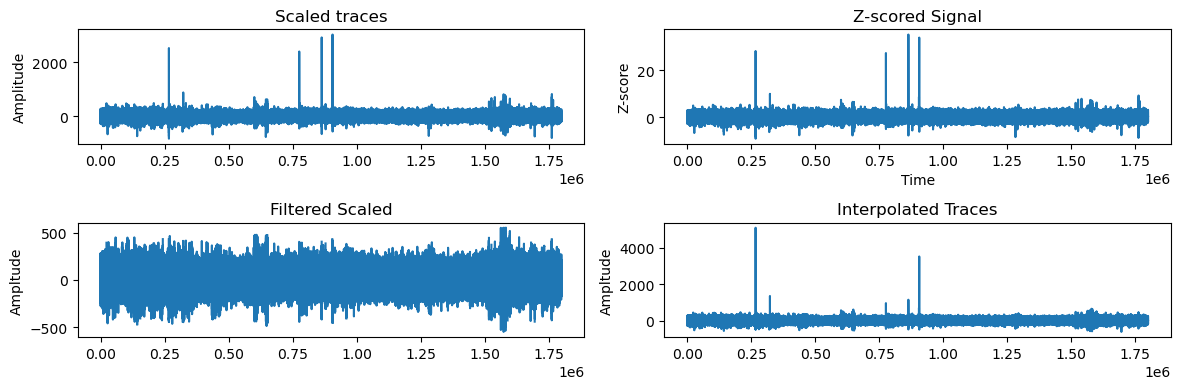

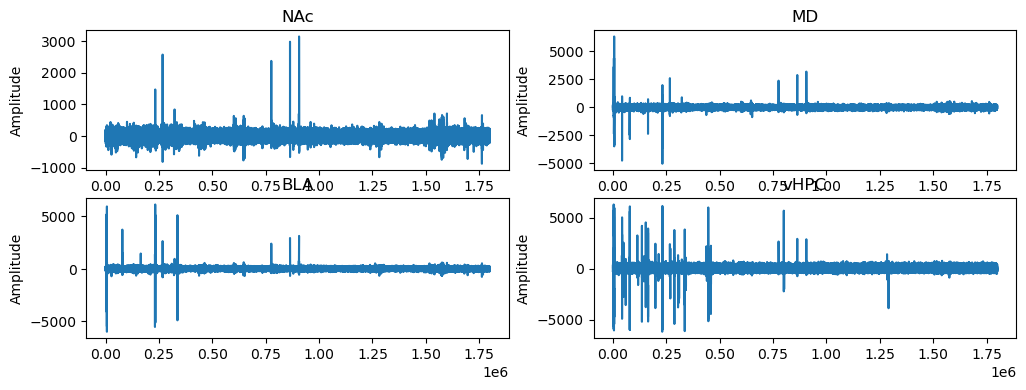

Power Calculated
Power Calculated
Power Calculated
original (3620, 500, 5) int (3599, 500, 5) rms (3599, 500, 5) no filter (3599, 500, 5)


/scratch/local/66819496/ipykernel_3982663/1491009387.py:25: RuntimeWarning: Mean of empty slice
  event_snippet = np.nanmean(event_snippet, axis=0)


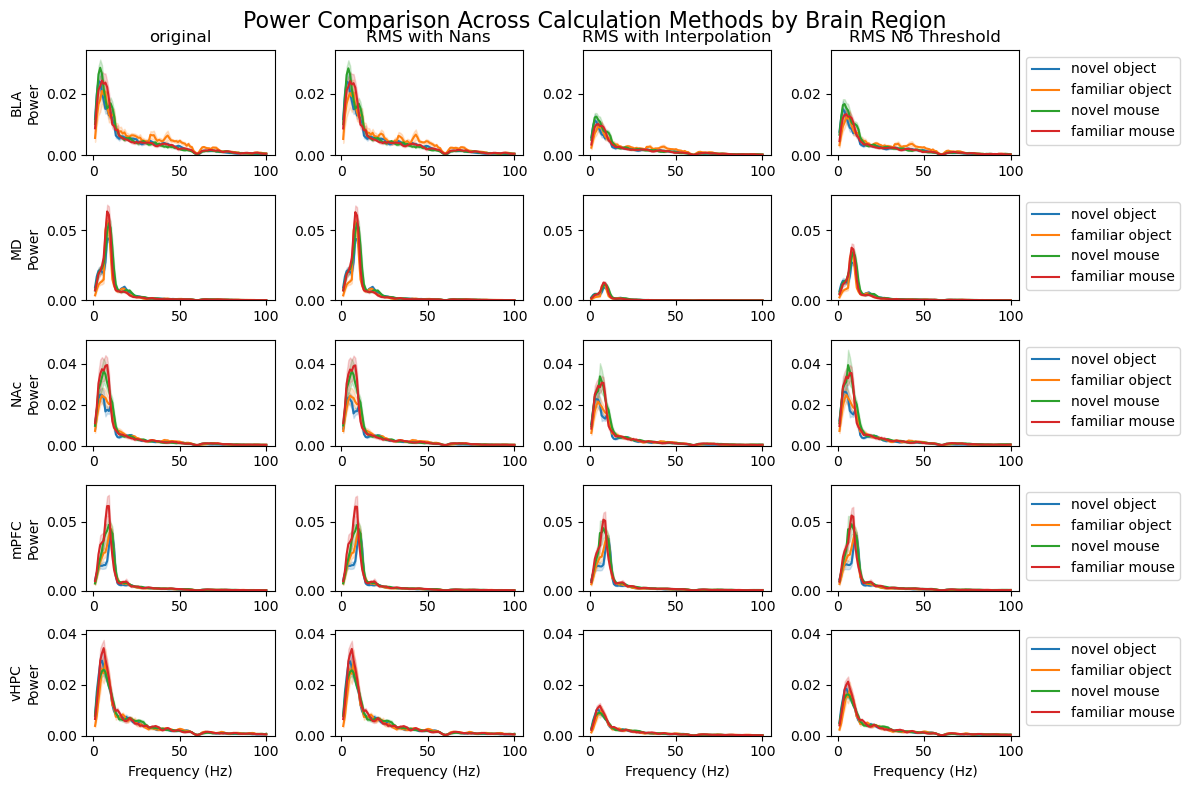

not int 0.04223395387607669
int 0.0
original 0.05392265193370166


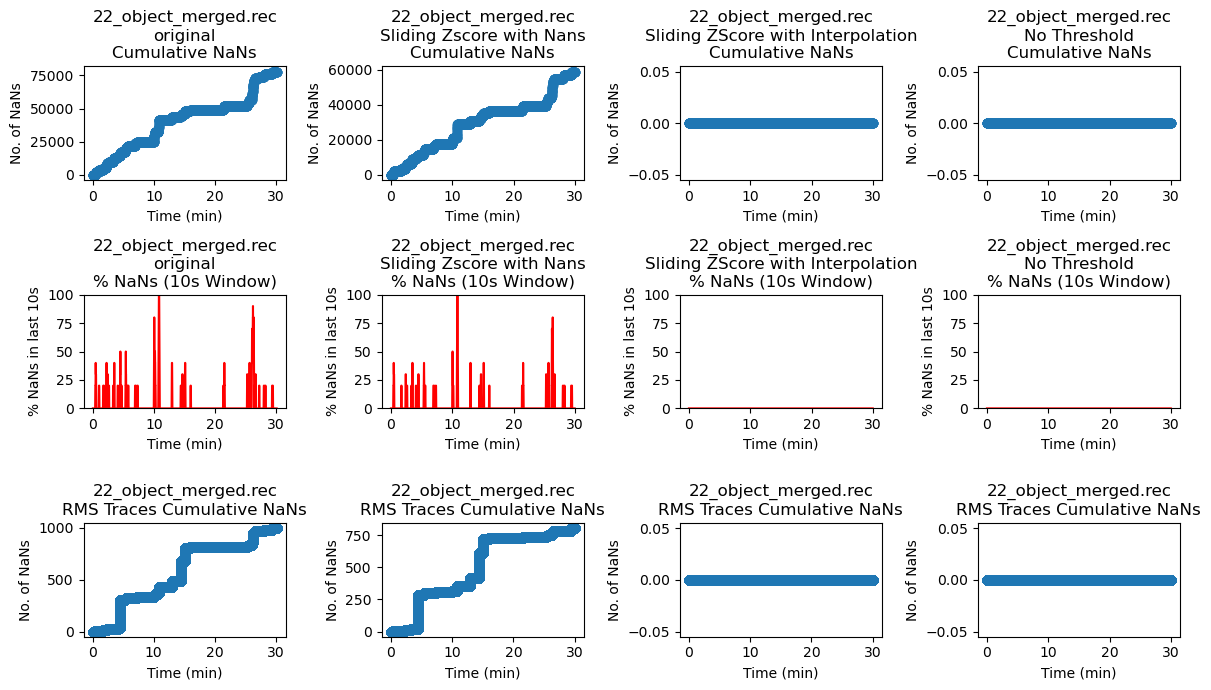

32_object_merged.rec
(1830000, 5)
(1830000, 5)


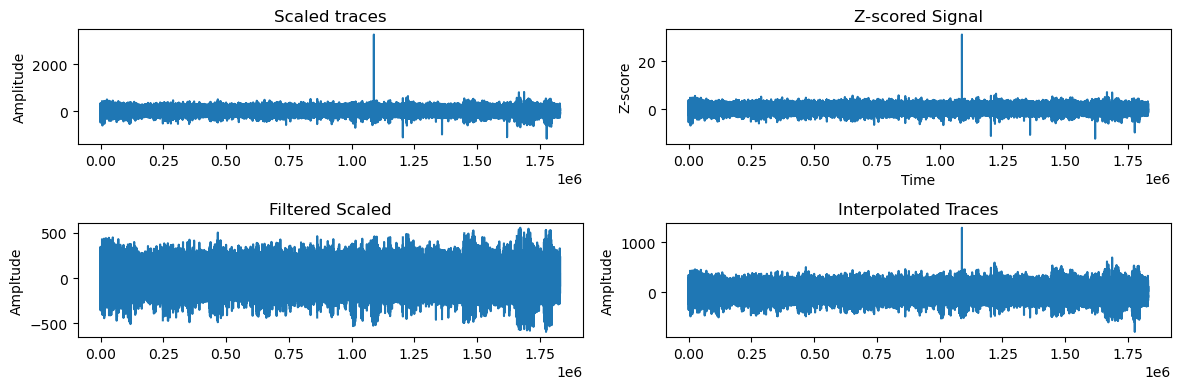

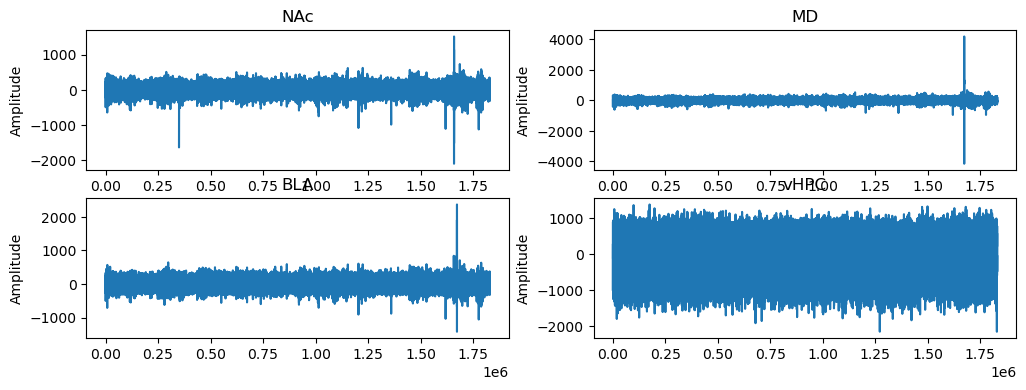

Power Calculated
Power Calculated
Power Calculated
original (3660, 500, 5) int (3659, 500, 5) rms (3659, 500, 5) no filter (3659, 500, 5)


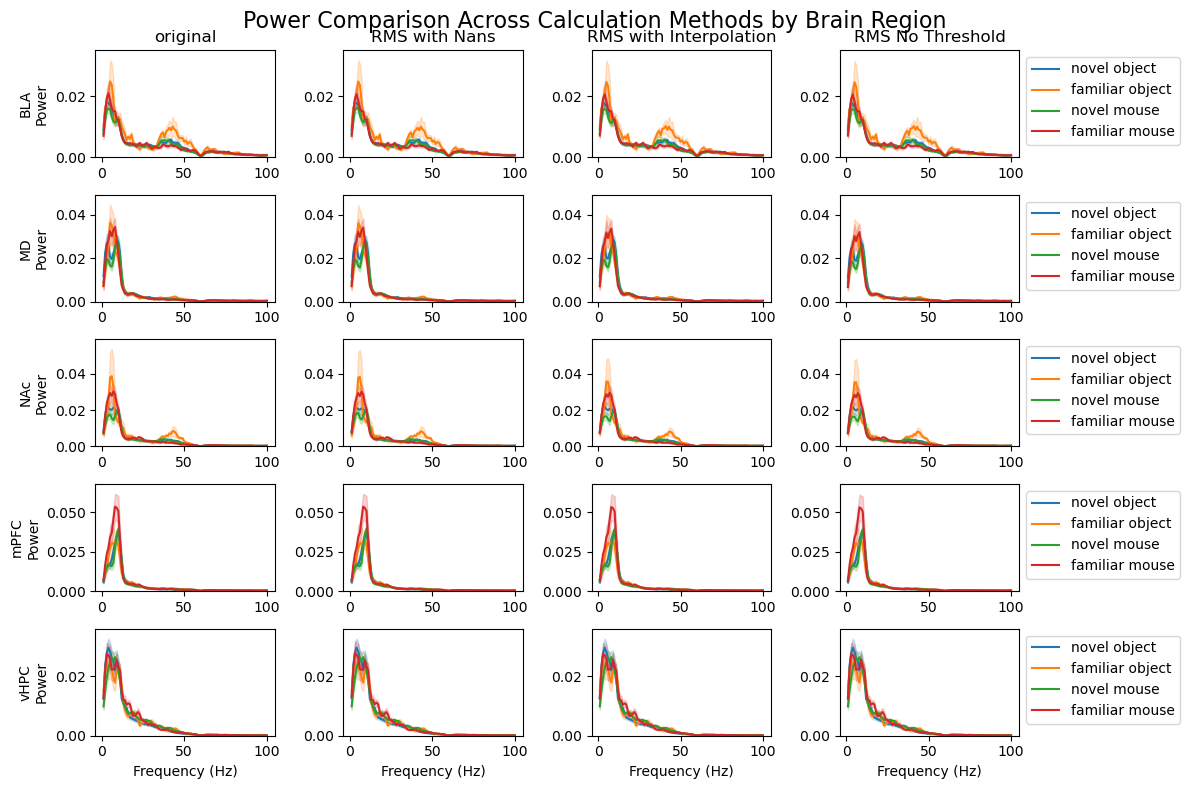

not int 0.041705383984695275
int 0.0
original 0.05540983606557377


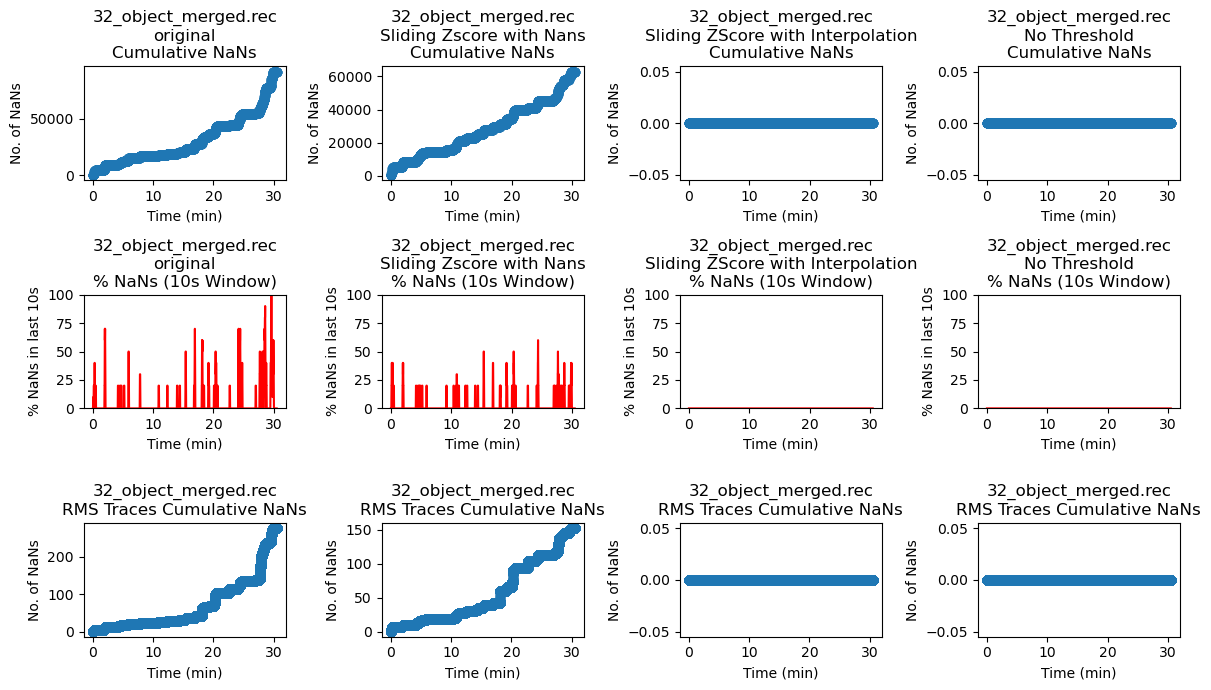

41_object_merged.rec
(1830000, 5)
(1830000, 5)


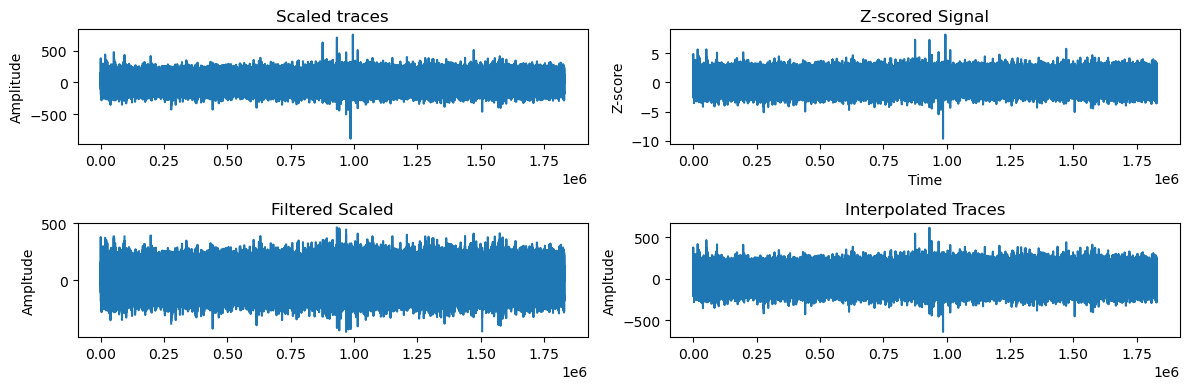

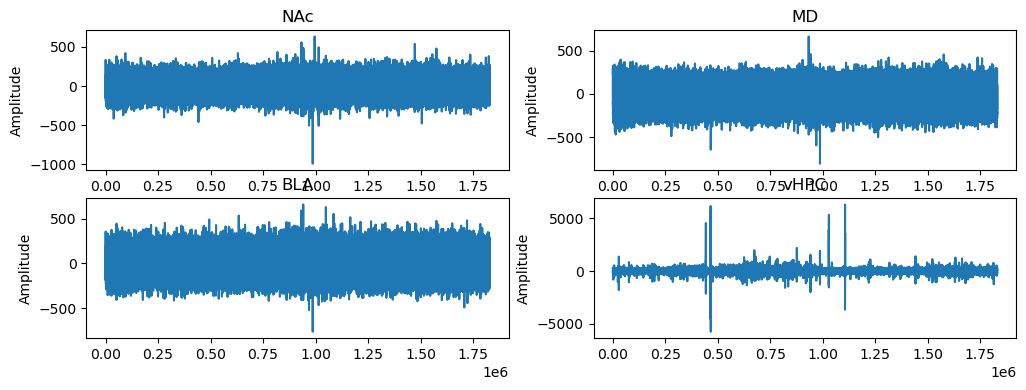

Power Calculated
Power Calculated
Power Calculated
original (3659, 500, 5) int (3659, 500, 5) rms (3659, 500, 5) no filter (3659, 500, 5)


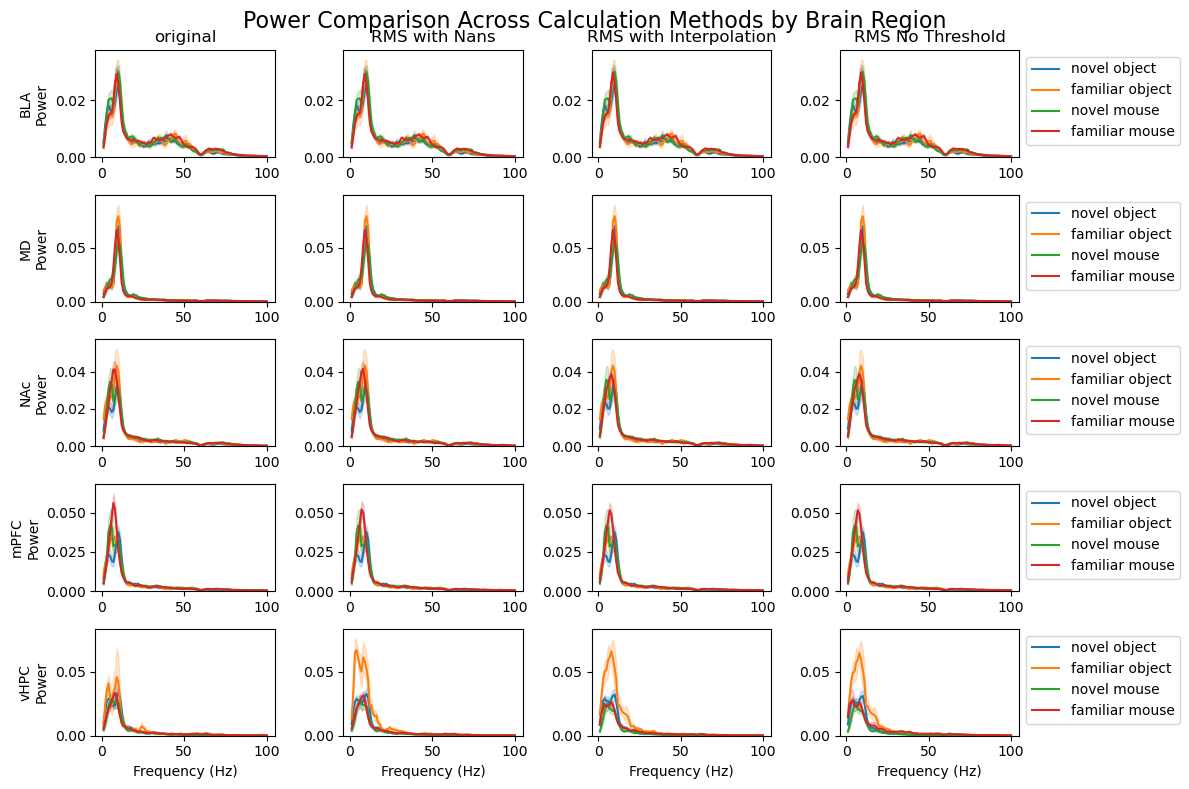

not int 0.03853511888494124
int 0.0
original 0.04820989341350096


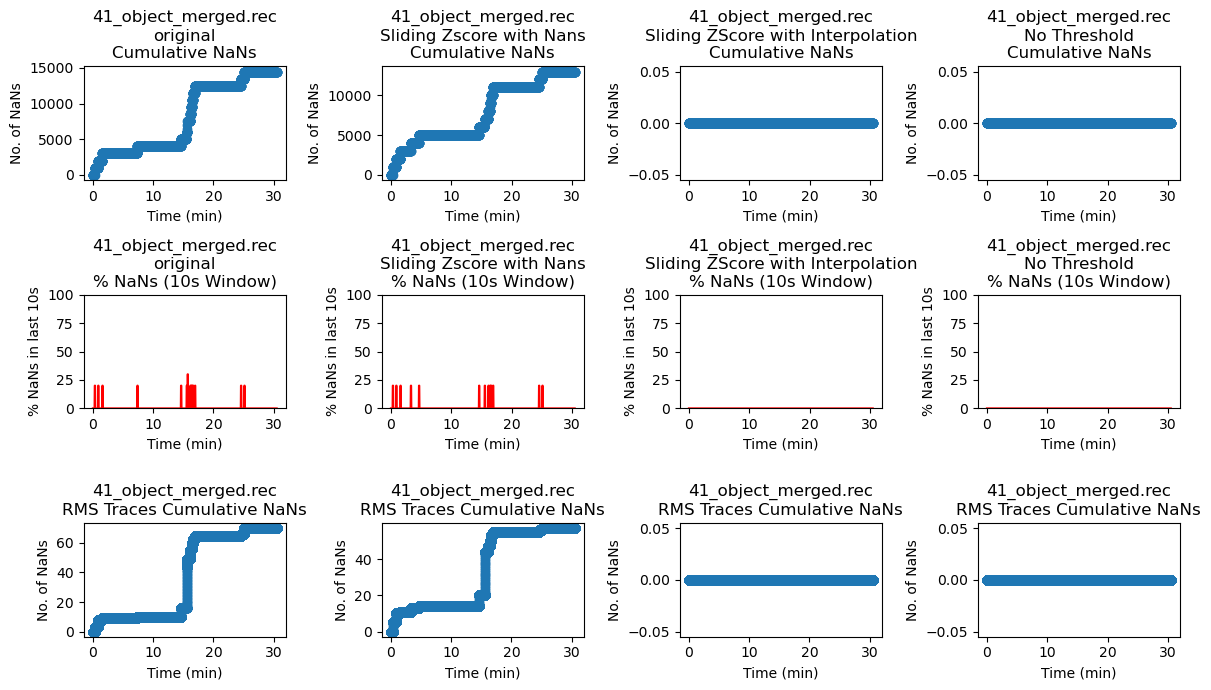

31_object_merged.rec
(1830000, 5)
(1830000, 5)


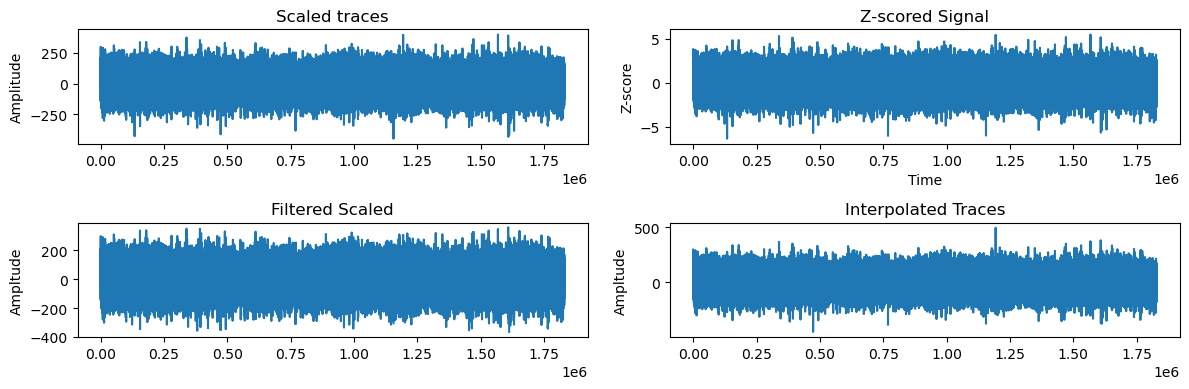

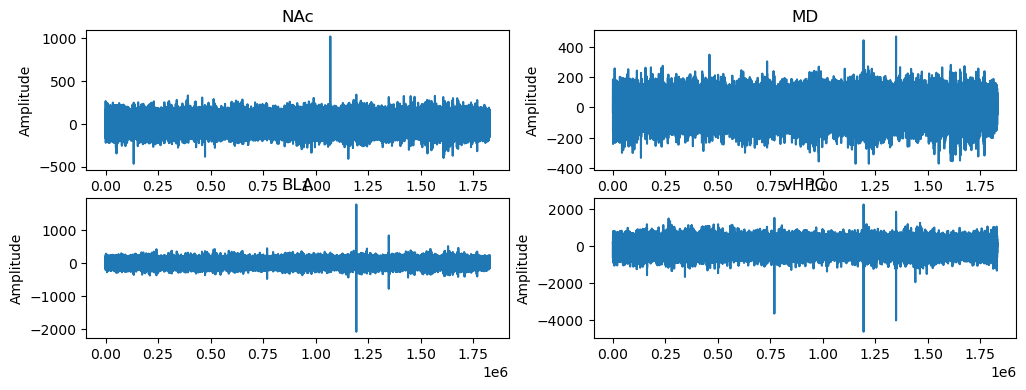

Power Calculated
Power Calculated
Power Calculated
original (3659, 500, 5) int (3659, 500, 5) rms (3659, 500, 5) no filter (3659, 500, 5)


/blue/npadillacoreano/mcum/conda/envs/lfp_env/lib/python3.11/site-packages/numpy/_core/_methods.py:223: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/scratch/local/66819496/ipykernel_3982663/1491009387.py:243: RuntimeWarning: All-NaN slice encountered
  y_max = max(y_max, np.nanmax(y + y_sem))


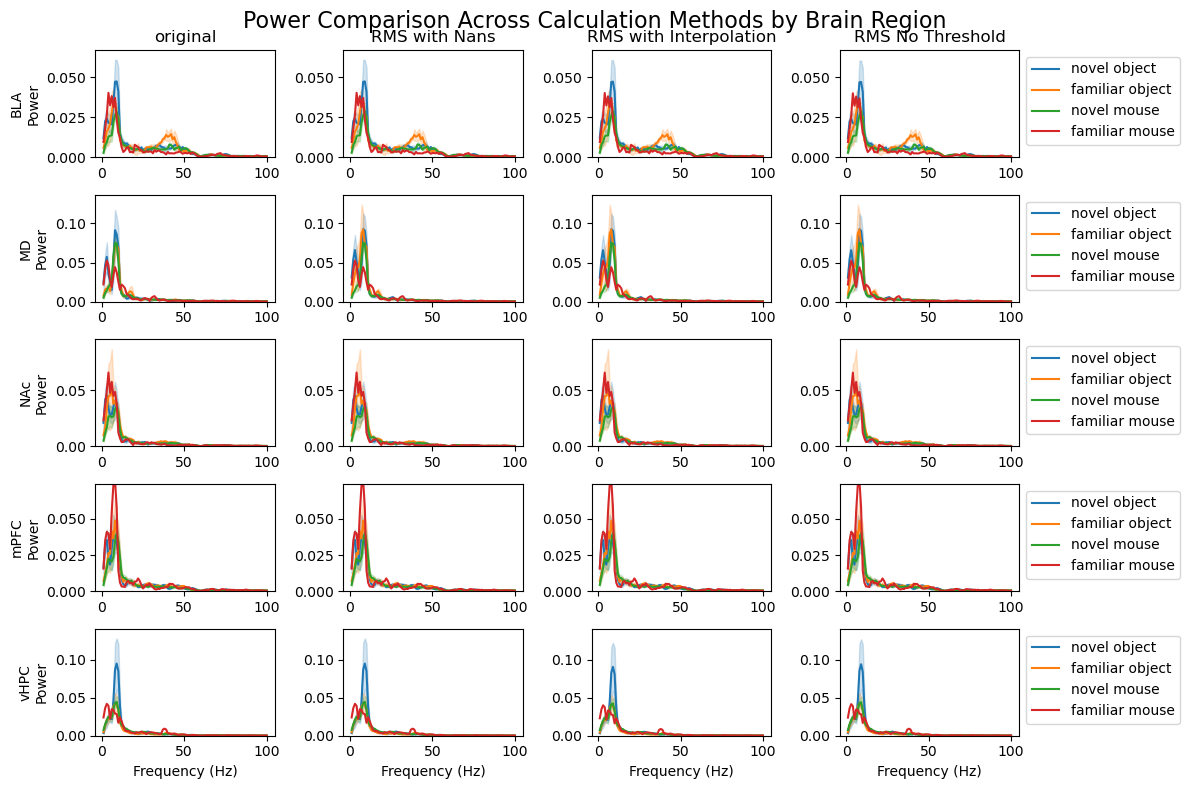

not int 0.015304728067778082
int 0.0
original 0.01639792292976223


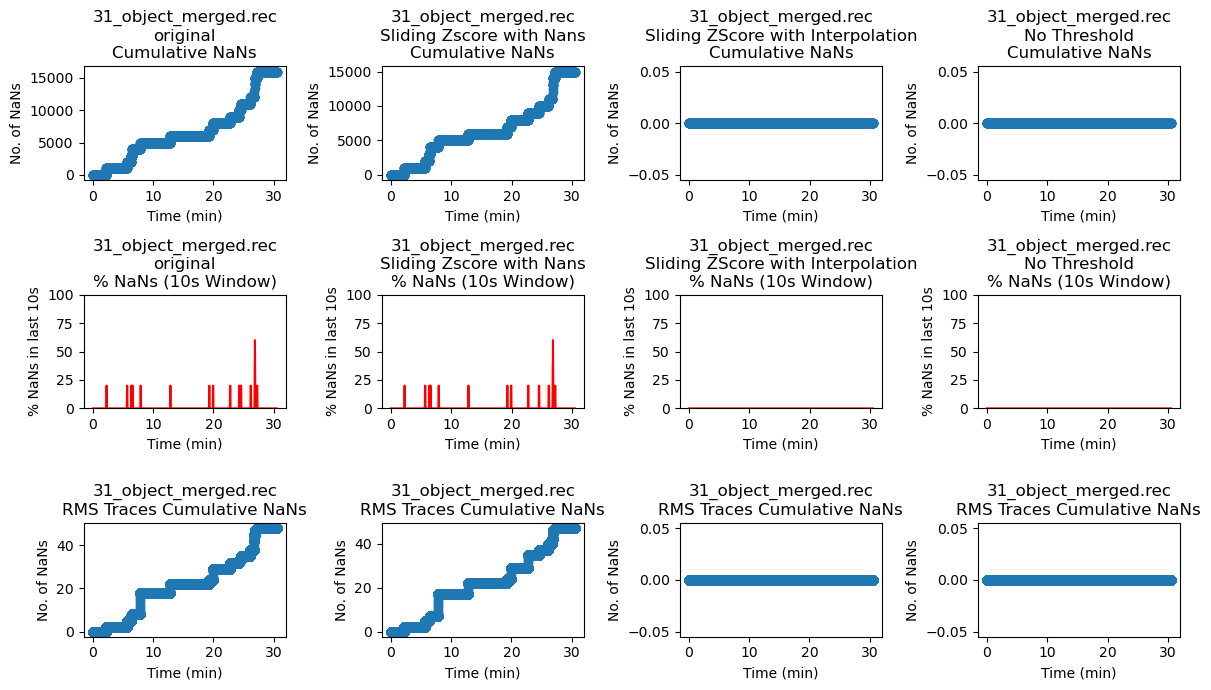

44_object_merged.rec
(1800000, 5)
(1800000, 5)


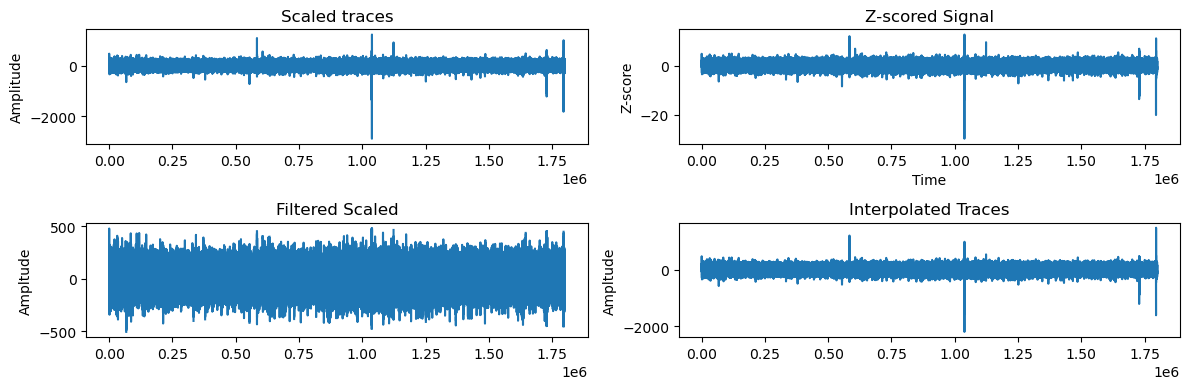

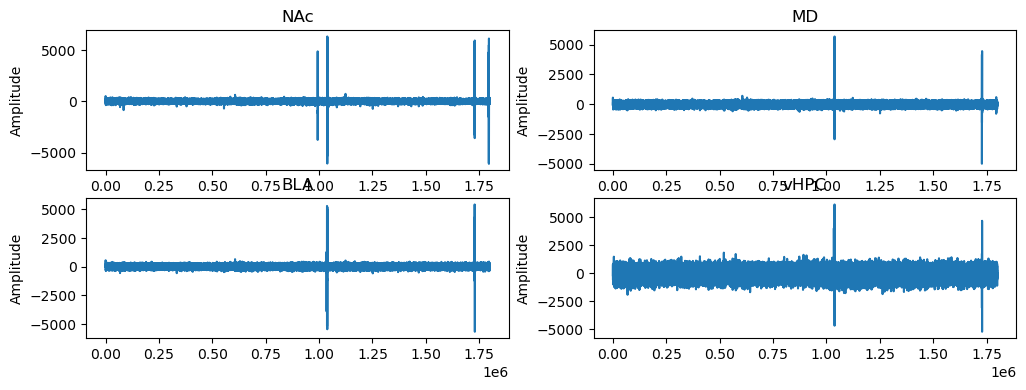

Power Calculated
Power Calculated
Power Calculated
original (3618, 500, 5) int (3599, 500, 5) rms (3599, 500, 5) no filter (3599, 500, 5)


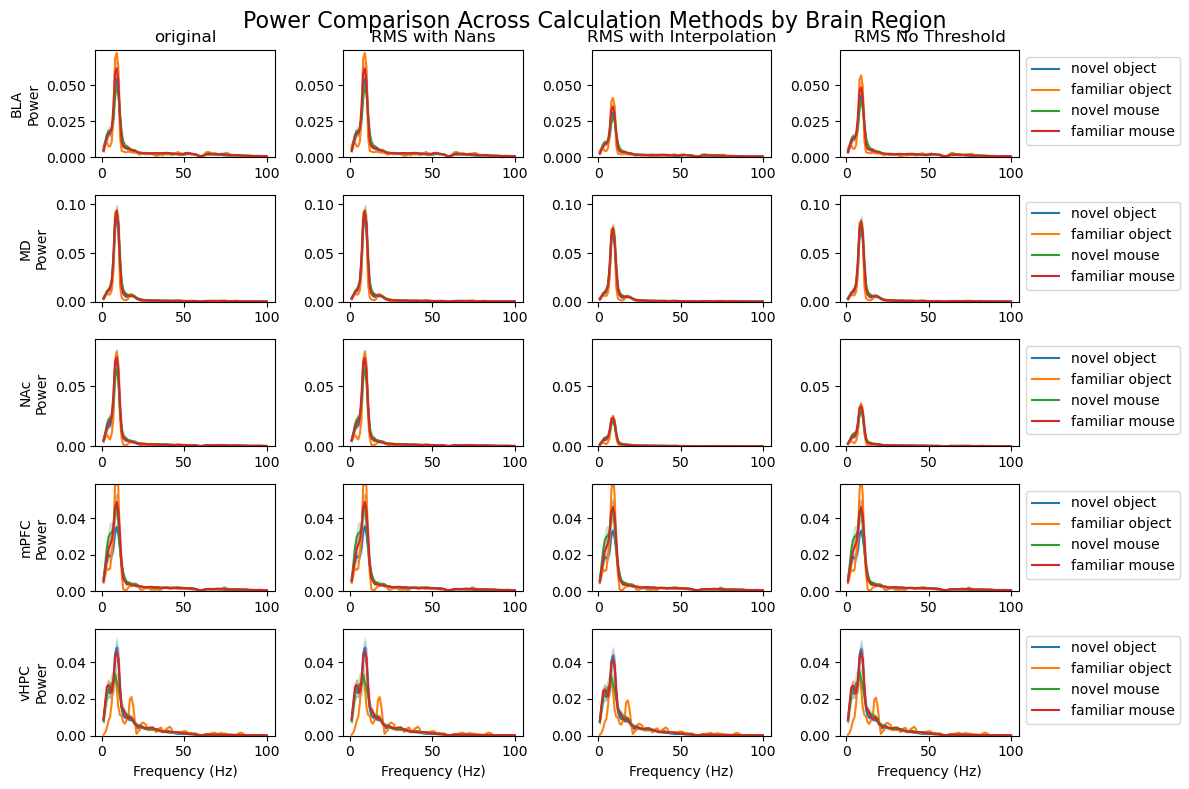

not int 0.011280911364267851
int 0.0
original 0.011166390270867884


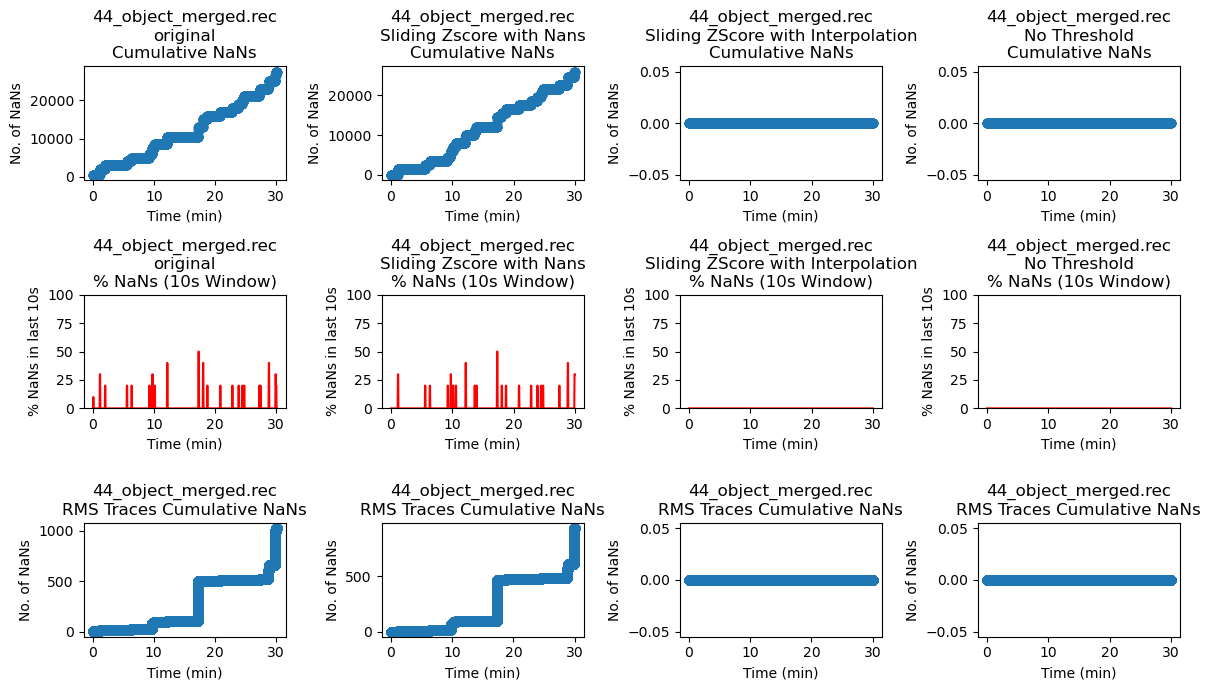

23_object_merged.rec
(1830000, 5)
(1830000, 5)


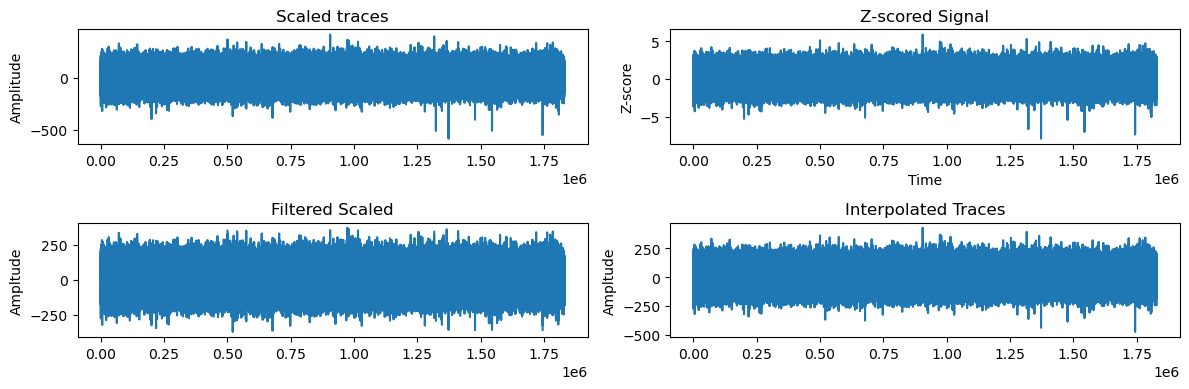

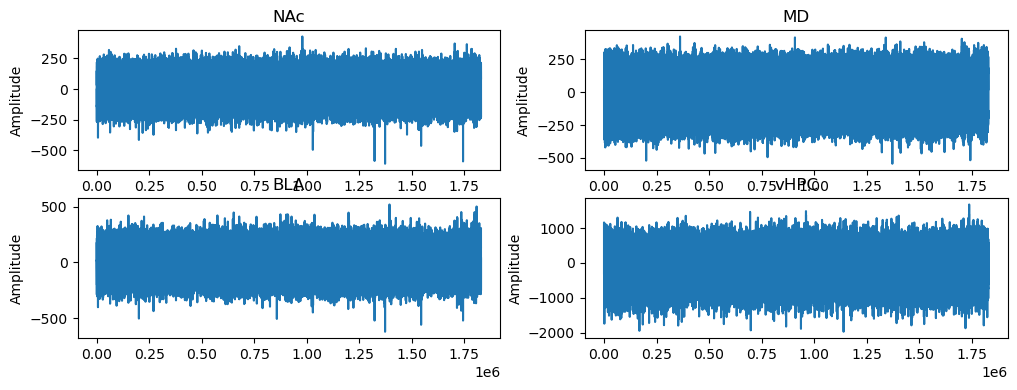

Power Calculated
Power Calculated
Power Calculated
original (3660, 500, 5) int (3659, 500, 5) rms (3659, 500, 5) no filter (3659, 500, 5)


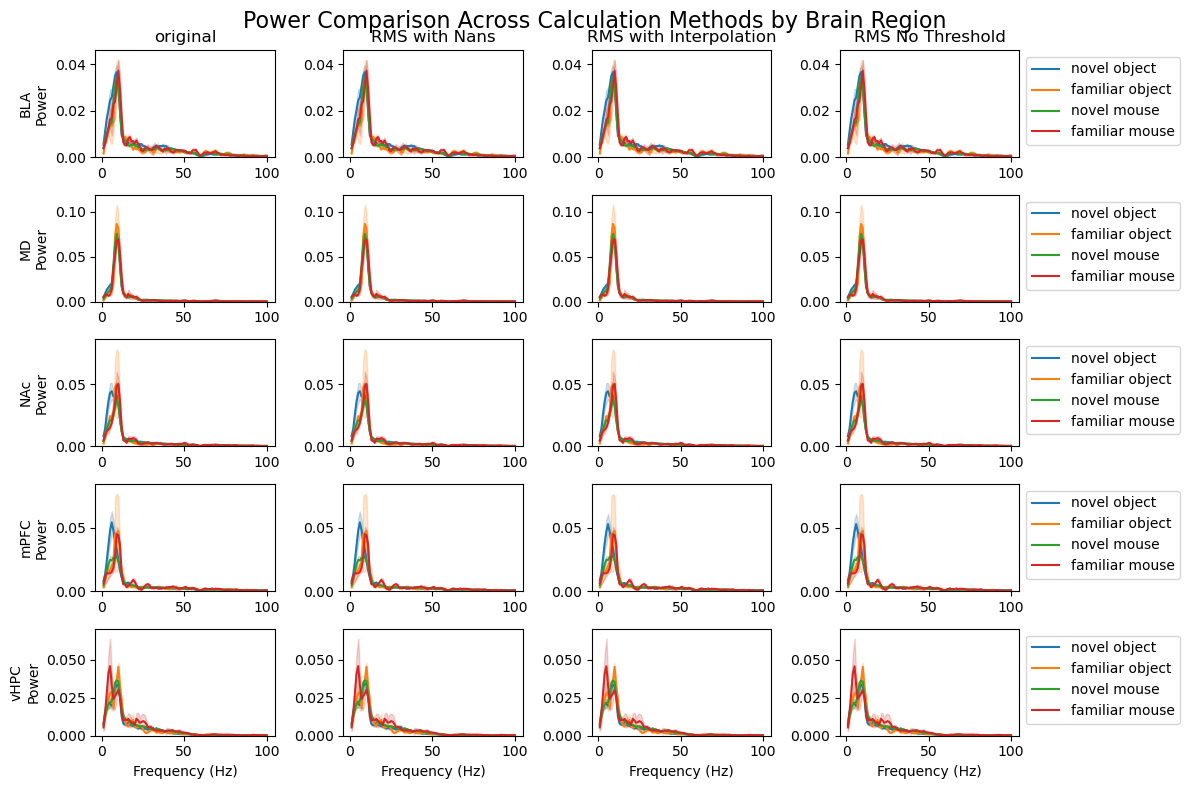

not int 0.007269745832194589
int 0.0
original 0.006120218579234973


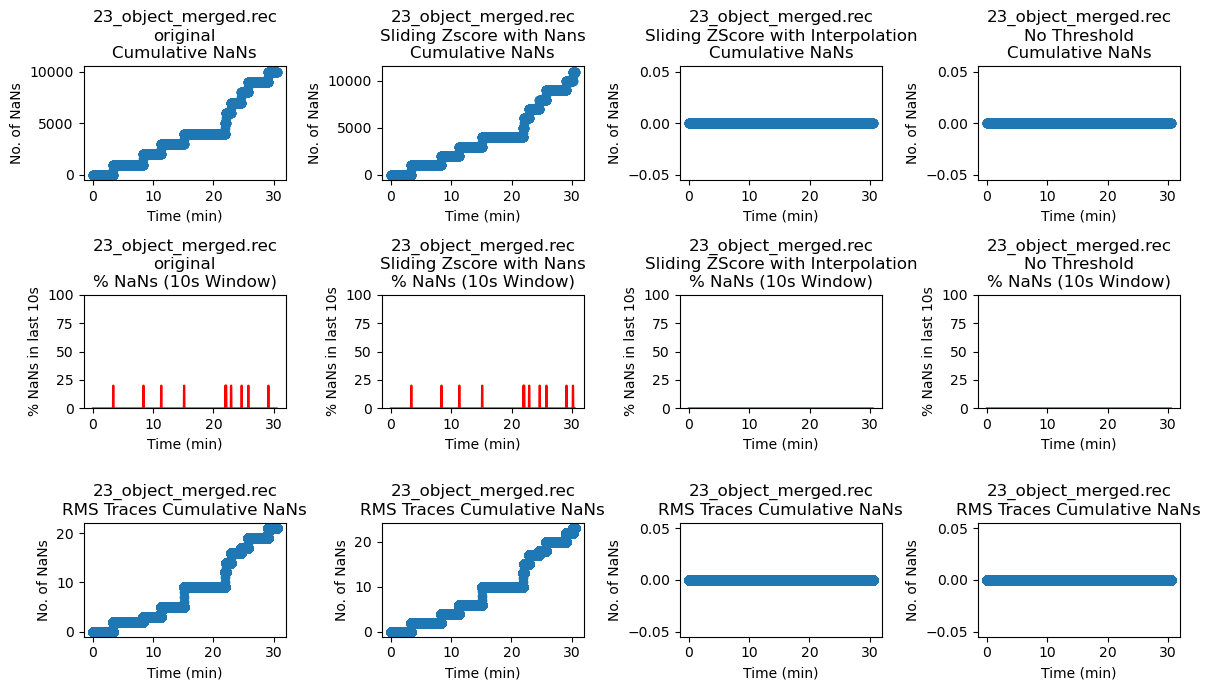

In [ ]:
for recording in object_collection.lfp_recordings:
    print(recording.name)
    processed_data = process_data_with_threshold(recording, threshold=5, time_window=30)
    processed_data2 = process_data_with_threshold(recording, threshold=10000, time_window=30)
    plot_threshold_analysis(processed_data)
    plot_all_regions(processed_data['original_traces'], recording.brain_region_dict)
    #find_and_plot_nan_snippets(processed_data, region_idx = 0, window_size=500, max_snippets=3)
    rms_traces = processed_data['rms_traces']
    rms_traces2 = processed_data2['rms_traces']
    int_traces = processed_data['interpolated_rms']
    original_power = recording.power
    rms_power = connect.calculate_power(rms_traces, 1000, 2, 1, 0.5) 
    int_power = connect.calculate_power(int_traces, 1000, 2, 1, 0.5)
    rms_power2 = connect.calculate_power(rms_traces2, 1000, 2, 1, 0.5)
    
    print('original', original_power.shape, 'int', int_power.shape, 'rms', rms_power.shape, 'no filter', rms_power2.shape)
    power_averages(recording, events = ['novel object', 'familiar object', 'novel mouse', 'familiar mouse'], modes = [original_power, rms_power, int_power, rms_power2],
                   titles = ['original', 'RMS with Nans', 'RMS with Interpolation', 'RMS No Threshold'], plot = True )
    print('not int', np.isnan(rms_power).sum() / rms_power.size)
    print('int',  np.isnan(int_power).sum() / int_power.size)
    print('original', np.isnan(recording.power).sum() / recording.power.size)
    plot_nan_analysis(recording, powers = [original_power, rms_power, int_power, rms_power2], 
                      titles = [ 'original', 'Sliding Zscore with Nans', 'Sliding ZScore with Interpolation', 'No Threshold',], 
                      rms_traces = [recording.rms_traces, rms_traces, int_traces, rms_traces2, ],
                      window_size = 10)

In [51]:
from importlib import reload
from lfp.lfp_analysis.LFP_collection import LFPCollection
from lfp.lfp_analysis.LFP_recording import LFPRecording
reload(lfpa)
def plot_spectogram(lfp_collection, events, mode, event_len, baseline=None, pre_window = 0, post_window = 0, freq_range=(0,100)):
      # Process collection vs single recording
    if isinstance(lfp_collection, LFPCollection):
        recordings = lfp_collection.lfp_recordings
    elif isinstance(lfp_collection, LFPRecording):
        recordings = [lfp_collection]
    elif isinstance(lfp_collection, list): 
        recordings = lfp_collection
    else:
        raise TypeError("lfp_collection must be either LFPCollection or LFPRecording")
    
    # Dictionary to store the average event data for each event type
    event_averages_dict = {}
    
    # Process each event type
    for i in range(len(events)):
        all_events = []
        for recording in recordings:
            # Events shape: [trials, time, freq, regions]
            recording_events = lfpa.__get_events__(recording, events[i], mode, event_len, 
                                                  pre_window, post_window, average=False)
            if baseline is not None:
                adj_averages = lfpa.__baseline_diff__(
                    recording, recording_events, baseline[i], mode, event_len, 
                    pre_window=0, post_window=0, average = False
                )
                all_events.extend(adj_averages)
            else:
                all_events.extend(recording_events)
        
        # Calculate average across trials for this event type
        average_event = np.nanmean(np.array(all_events), axis=0)
        event_averages_dict[events[i]] = average_event
    
    # Get dimensions and axes from the first event (assuming all have same shape)
   
    first_event = list(event_averages_dict.values())[0]
    n_timepoints, n_freqs, n_regions = first_event.shape
   
        
    time_axis = np.linspace(-pre_window, event_len+post_window, n_timepoints)
    freq_axis = range(freq_range[0], freq_range[1])

        # Get region names
    region_names = [f'{lfp_collection.brain_region_dict.inverse[i]}' for i in range(n_regions)]

    # Calculate vmin and vmax per brain region across all events
    region_bounds = []
    for region_idx in range(n_regions):
        # Collect data for this region across all events
        region_data = np.array([])
        for event_data in event_averages_dict.values():
            # Extract only the frequency range we want to display 
            sliced_data = event_data[:, freq_range[0]:freq_range[1], region_idx]
            if region_data.size == 0:
                region_data = sliced_data.flatten()
            else:
                region_data = np.concatenate([region_data, sliced_data.flatten()])
        # Calculate percentiles for this region's data
        region_vmin = np.percentile(region_data, 5)  # 5th percentile to avoid outliers
        region_vmax = np.percentile(region_data, 95)  # 95th percentile to avoid outliers
        
        # Store bounds for this region
        region_bounds.append((region_vmin, region_vmax))
    
    # Setup figure layout - rows are brain regions, columns are event types
    n_rows = n_regions
    n_cols = len(events)
    
    # Adjust figure size based on number of subplots
    fig_size = (15, 10)
    adjusted_width = max(fig_size[0], 4 * n_cols)
    adjusted_height = max(fig_size[1], 3 * n_rows)
    
    # Create figure with extra space for everything
    fig = plt.figure(figsize=(adjusted_width + 4, adjusted_height))
    
    # Create layout with extra space for labels and colorbars
    # Main gridspec for all content
    outer_gs = fig.add_gridspec(1, 2, width_ratios=[0.15, 0.85], wspace=0.0)
    
    # Left side for region labels
    labels_gs = outer_gs[0].subgridspec(n_rows, 1)
    
    # Right side for plots and colorbars
    right_gs = outer_gs[1].subgridspec(1, 2, width_ratios=[0.95, 0.015], wspace=0.01)
    
    # Further divide the plots area into a grid for each region and event
    plots_gs = right_gs[0].subgridspec(n_rows, n_cols, hspace=0.3, wspace=0.3)
    
    # And the colorbar area into a column for each region
    cbar_gs = right_gs[1].subgridspec(n_rows, 1)
    
    # Create axes
    label_axes = []
    plot_axes = []
    cbar_axes = []
    
    # Create label axes
    for row_idx in range(n_rows):
        label_ax = fig.add_subplot(labels_gs[row_idx, 0])
        label_ax.axis('off')  # Hide axis elements
        label_axes.append(label_ax)
    
    # Create plot axes
    for row_idx in range(n_rows):
        row_axes = []
        for col_idx in range(n_cols):
            ax = fig.add_subplot(plots_gs[row_idx, col_idx])
            row_axes.append(ax)
        plot_axes.append(row_axes)
    
    # Create colorbar axes
    for row_idx in range(n_rows):
        cbar_ax = fig.add_subplot(cbar_gs[row_idx, 0])
        cbar_axes.append(cbar_ax)
    
    # Add the region labels
    for row_idx, region_idx in enumerate(range(n_regions)):
        if row_idx < len(region_names):
            label_axes[row_idx].text(0.5, 0.5, region_names[region_idx],
                                     fontsize=18, fontweight='bold',
                                     rotation=90, ha='center', va='center',
                                     transform=label_axes[row_idx].transAxes)
    
    # Plot spectrograms and add colorbars
    for row_idx, region_idx in enumerate(range(n_regions)):
        region_vmin, region_vmax = region_bounds[region_idx]
        
        # Reference to store the last image for colorbar
        region_im = None
        
        # Plot each event for this region
        for col_idx, event in enumerate(events):
            ax = plot_axes[row_idx][col_idx]
            
            # Get the event data for this specific region
            event_data = event_averages_dict[event][:, freq_range[0]:freq_range[1], region_idx].T
            
            # Plot the spectrogram
            im = ax.pcolormesh(time_axis, freq_axis, event_data,
                              cmap='viridis', vmin=region_vmin, vmax=region_vmax, shading='gouraud')
            
            region_im = im  # Save for colorbar
            
            # Add vertical line at t=0 (event onset)
            ax.axvline(x=0, color='white', linestyle='--', alpha=0.7)
            
            # Set labels only on left and bottom edges
            if col_idx == 0:
                ax.set_ylabel('Frequency (Hz)')
            
            if row_idx == n_rows - 1:
                ax.set_xlabel('Time (s)')
            
            # Add event type title
            if row_idx == 0:
                ax.set_title(f"{event}", fontsize=14, fontweight='bold')
        
        # Add colorbar for this region
        if region_im is not None:
            cbar = plt.colorbar(region_im, cax=cbar_axes[row_idx])
            cbar.set_label('Power', rotation=270, labelpad=15)
    
    # Add overall title
    #fig.suptitle(f'Spectrograms by Brain Region and Event Type', fontsize=16, y=0.98)
    

def plot_averages(power_dict, lfp_collection,colors, bar_width = None, freq_range_dict = None):
    # Get the single event (assuming one event in all conditions)
    first_condition = list(power_dict.keys())[0]
    #event = list(power_dict[first_condition].keys())[0]
   
    # Process data for each condition
    condition_data = {}
    for condition, powers in power_dict.items():
        if freq_range_dict is None:
            [unflipped, flipped] = lfpa.band_calcs(powers)
        else:
             [unflipped, flipped] = diff_band_calcs(powers, freq_range_dict)
        brain_regions = np.empty(len(lfp_collection.brain_region_dict.keys()), dtype="<U10")
        for i in range(len(lfp_collection.brain_region_dict.keys())):
            brain_regions[i] = lfp_collection.brain_region_dict.inverse[i]
            
        avg_values = {key: {subset: [] for subset in brain_regions} for key in flipped.keys()}
        sem_values = {key: {subset: [] for subset in brain_regions} for key in flipped.keys()}
    
        event = list(unflipped.keys())[0]
        
        for key in flipped.keys():
            for i, subset in enumerate(brain_regions):
                avg_values[key][subset] = np.nanmean(flipped[key][event][:, i])
                sem_values[key][subset] = stats.sem(flipped[key][event][:, i], nan_policy="omit")
                    
        condition_data[condition] = {'avg': avg_values, 'sem': sem_values}
    
    # Plotting
    # Calculate number of subplots needed (one per frequency band)
    freq_bands = list(flipped.keys())
    n_bands = len(freq_bands)
    n_rows = (n_bands + 1) // 2  # 2 plots per row, rounded up
    
    
   
    
    # Plotting parameters
    if bar_width is None:
        bar_width = 0.35
    conditions = list(power_dict.keys())
    fig, axs = plt.subplots(n_rows, 2, figsize=(7.5*len(conditions), 5*n_rows))
    fig.suptitle(f"Average Power by Frequency Band", fontsize=24, y = 1.1)
    axs = axs.ravel()  # Flatten axes array for easier indexing
    for i, band in enumerate(freq_bands):
        ax = axs[i]
        x = np.arange(len(brain_regions))
        
        for j, condition in enumerate(conditions):
            positions = x + (j - len(conditions)/2 + 0.5) * bar_width
            ax.bar(positions,
                  [condition_data[condition]['avg'][band][region] for region in brain_regions],
                  width=bar_width,
                  yerr=[condition_data[condition]['sem'][band][region] for region in brain_regions],
                  capsize=5,
                  linewidth=2,
                  error_kw={"elinewidth": 2, "capthick": 2},
                  label=condition,
                  color=colors[j],
                  edgecolor = 'black')  # Add hatching for second condition
        
        ax.set_title(band, fontsize=20)
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        ax.spines['bottom'].set_linewidth(2)
        ax.spines['left'].set_linewidth(2)
        ax.axhline(y=0, color="black", linestyle="--", alpha=0.8)
        ax.tick_params(axis='both', which='major', labelsize=14)
        ax.set_xticks(x+.25)
        ax.set_xticklabels(brain_regions, rotation=0, ha='right', fontsize = 18)
        ax.set_ylabel('Power', fontsize = 18)
        #if i == 0:  # Add legend to first subplot
        ax.legend(fontsize=14, frameon=False, bbox_to_anchor = (1,1))
        ax.yaxis.set_major_formatter(ScalarFormatter(useMathText=True))
        ax.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
        ax.yaxis.get_offset_text().set_fontsize(14) 
    # Remove empty subplots
    for i in range(len(freq_bands), len(axs)):
        fig.delaxes(axs[i])
        
    plt.tight_layout()
    plt.show()


def plot_coherence_bar(coherence_dict, lfp_collection, colors, bar_width = None):
    # Get the single event (assuming one event in all conditions)
    first_condition = list(coherence_dict.keys())[0]
    event = list(coherence_dict[first_condition].keys())[0]
    
    # Get brain region pairs
    region_dict = lfp_collection.brain_region_dict
    brain_regions = list(combinations(list((region_dict.keys())), 2))
    
    # Process data for each condition
    condition_data = {}
    for condition, coherences in coherence_dict.items():
        [unflipped, flipped] = lfpa.band_calcs(coherences)
        
        avg_values = {key: {subset: [] for subset in brain_regions} for key in flipped.keys()}
        sem_values = {key: {subset: [] for subset in brain_regions} for key in flipped.keys()}
        event = list(unflipped.keys())[0]
        
        for key in flipped.keys():
            for i, subset in enumerate(brain_regions):
                pair_index_1 = region_dict[brain_regions[i][0]]
                pair_index_2 = region_dict[brain_regions[i][1]]
                avg_values[key][subset] = np.nanmean(flipped[key][event][:, pair_index_1, pair_index_2])
                sem_values[key][subset] = stats.sem(
                    flipped[key][event][:, pair_index_1, pair_index_2], 
                    nan_policy="omit"
                )
                    
        condition_data[condition] = {'avg': avg_values, 'sem': sem_values}
    
    # Plotting
    # Calculate number of subplots needed (one per frequency band)
    freq_bands = list(flipped.keys())
    n_bands = len(freq_bands)
    n_rows = (n_bands + 1) // 2  # 2 plots per row, rounded up
    conditions = list(coherence_dict.keys())
    fig, axs = plt.subplots(n_rows, 2, figsize=(10*len(conditions), 5*n_rows))
    fig.suptitle(f"Average Coherence by Frequency Band", fontsize=24, y =1.05)
    axs = axs.ravel()  # Flatten axes array for easier indexing
    
    # Plotting parameters
    if bar_width is None:
        bar_width = 0.35
    
    
    for i, band in enumerate(freq_bands):
        ax = axs[i]
        x = np.arange(len(brain_regions))
        
        for j, condition in enumerate(conditions):
            positions = x + (j - len(conditions)/2 + 0.5) * bar_width
            ax.bar(positions,
                  [condition_data[condition]['avg'][band][region] for region in brain_regions],
                  width=bar_width,
                  yerr=[condition_data[condition]['sem'][band][region] for region in brain_regions],
                  capsize=5,
                  linewidth=2,
                  error_kw={"elinewidth": 2, "capthick": 2},
                  label=condition,
                  color=colors[j],
                  edgecolor = 'black')  # Add hatching for second condition
        
        ax.set_title(band, fontsize=20, y = 1.1)
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        ax.spines['bottom'].set_linewidth(2)
        ax.spines['left'].set_linewidth(2)
        ax.axhline(y=0, color="black", linestyle="--", alpha=0.8)
        ax.tick_params(axis='both', which='major', labelsize=14)
        ax.set_xticks(x)
        # Format brain region pair labels
        region_labels = [f"{pair[0]}-{pair[1]}" for pair in brain_regions]
        ax.set_xticklabels(region_labels, rotation=45, ha='right')
        
        #if i == 0:  # Add legend to first subplot
        ax.legend(fontsize=14, frameon=False, bbox_to_anchor=(1,1))
            
        ax.set_ylabel("Coherence", fontsize = 18)
        #ax.set_ylim(.3,1)
    # Remove empty subplots
    for i in range(len(freq_bands), len(axs)):
        fig.delaxes(axs[i])
        
    plt.tight_layout()
    plt.show()
    
plot_spectogram(object_collection,events = ['novel object', 'familiar object', 'novel mouse', 'familiar mouse'], baseline = ['baseline', 'baseline','baseline','baseline'], mode = 'power', event_len = 3, pre_window = 3, freq_range = (0, 100))



AttributeError: 'LFPCollection' object has no attribute 'lfp_recordings'

/blue/npadillacoreano/mcum/SocialMemEphys/diff_fam_social_memory_ephys/lfp/lfp_analysis/LFP_analysis.py:128: RuntimeWarning: Mean of empty slice
  event_snippet = np.nanmean(event_snippet, axis=0)
/blue/npadillacoreano/mcum/SocialMemEphys/diff_fam_social_memory_ephys/lfp/lfp_analysis/LFP_analysis.py:380: RuntimeWarning: Mean of empty slice
  baseline_recording = np.nanmean(np.array(baseline_averages), axis=0)
/blue/npadillacoreano/mcum/SocialMemEphys/diff_fam_social_memory_ephys/lfp/lfp_analysis/LFP_analysis.py:455: RuntimeWarning: Mean of empty slice
  delta = np.nanmean(calculations[:, 0:4, ...], axis=1)
/blue/npadillacoreano/mcum/SocialMemEphys/diff_fam_social_memory_ephys/lfp/lfp_analysis/LFP_analysis.py:456: RuntimeWarning: Mean of empty slice
  theta = np.nanmean(calculations[:, 4:13, ...], axis=1)
/blue/npadillacoreano/mcum/SocialMemEphys/diff_fam_social_memory_ephys/lfp/lfp_analysis/LFP_analysis.py:458: RuntimeWarning: Mean of empty slice
  beta = np.nanmean(calculations[:, 13:

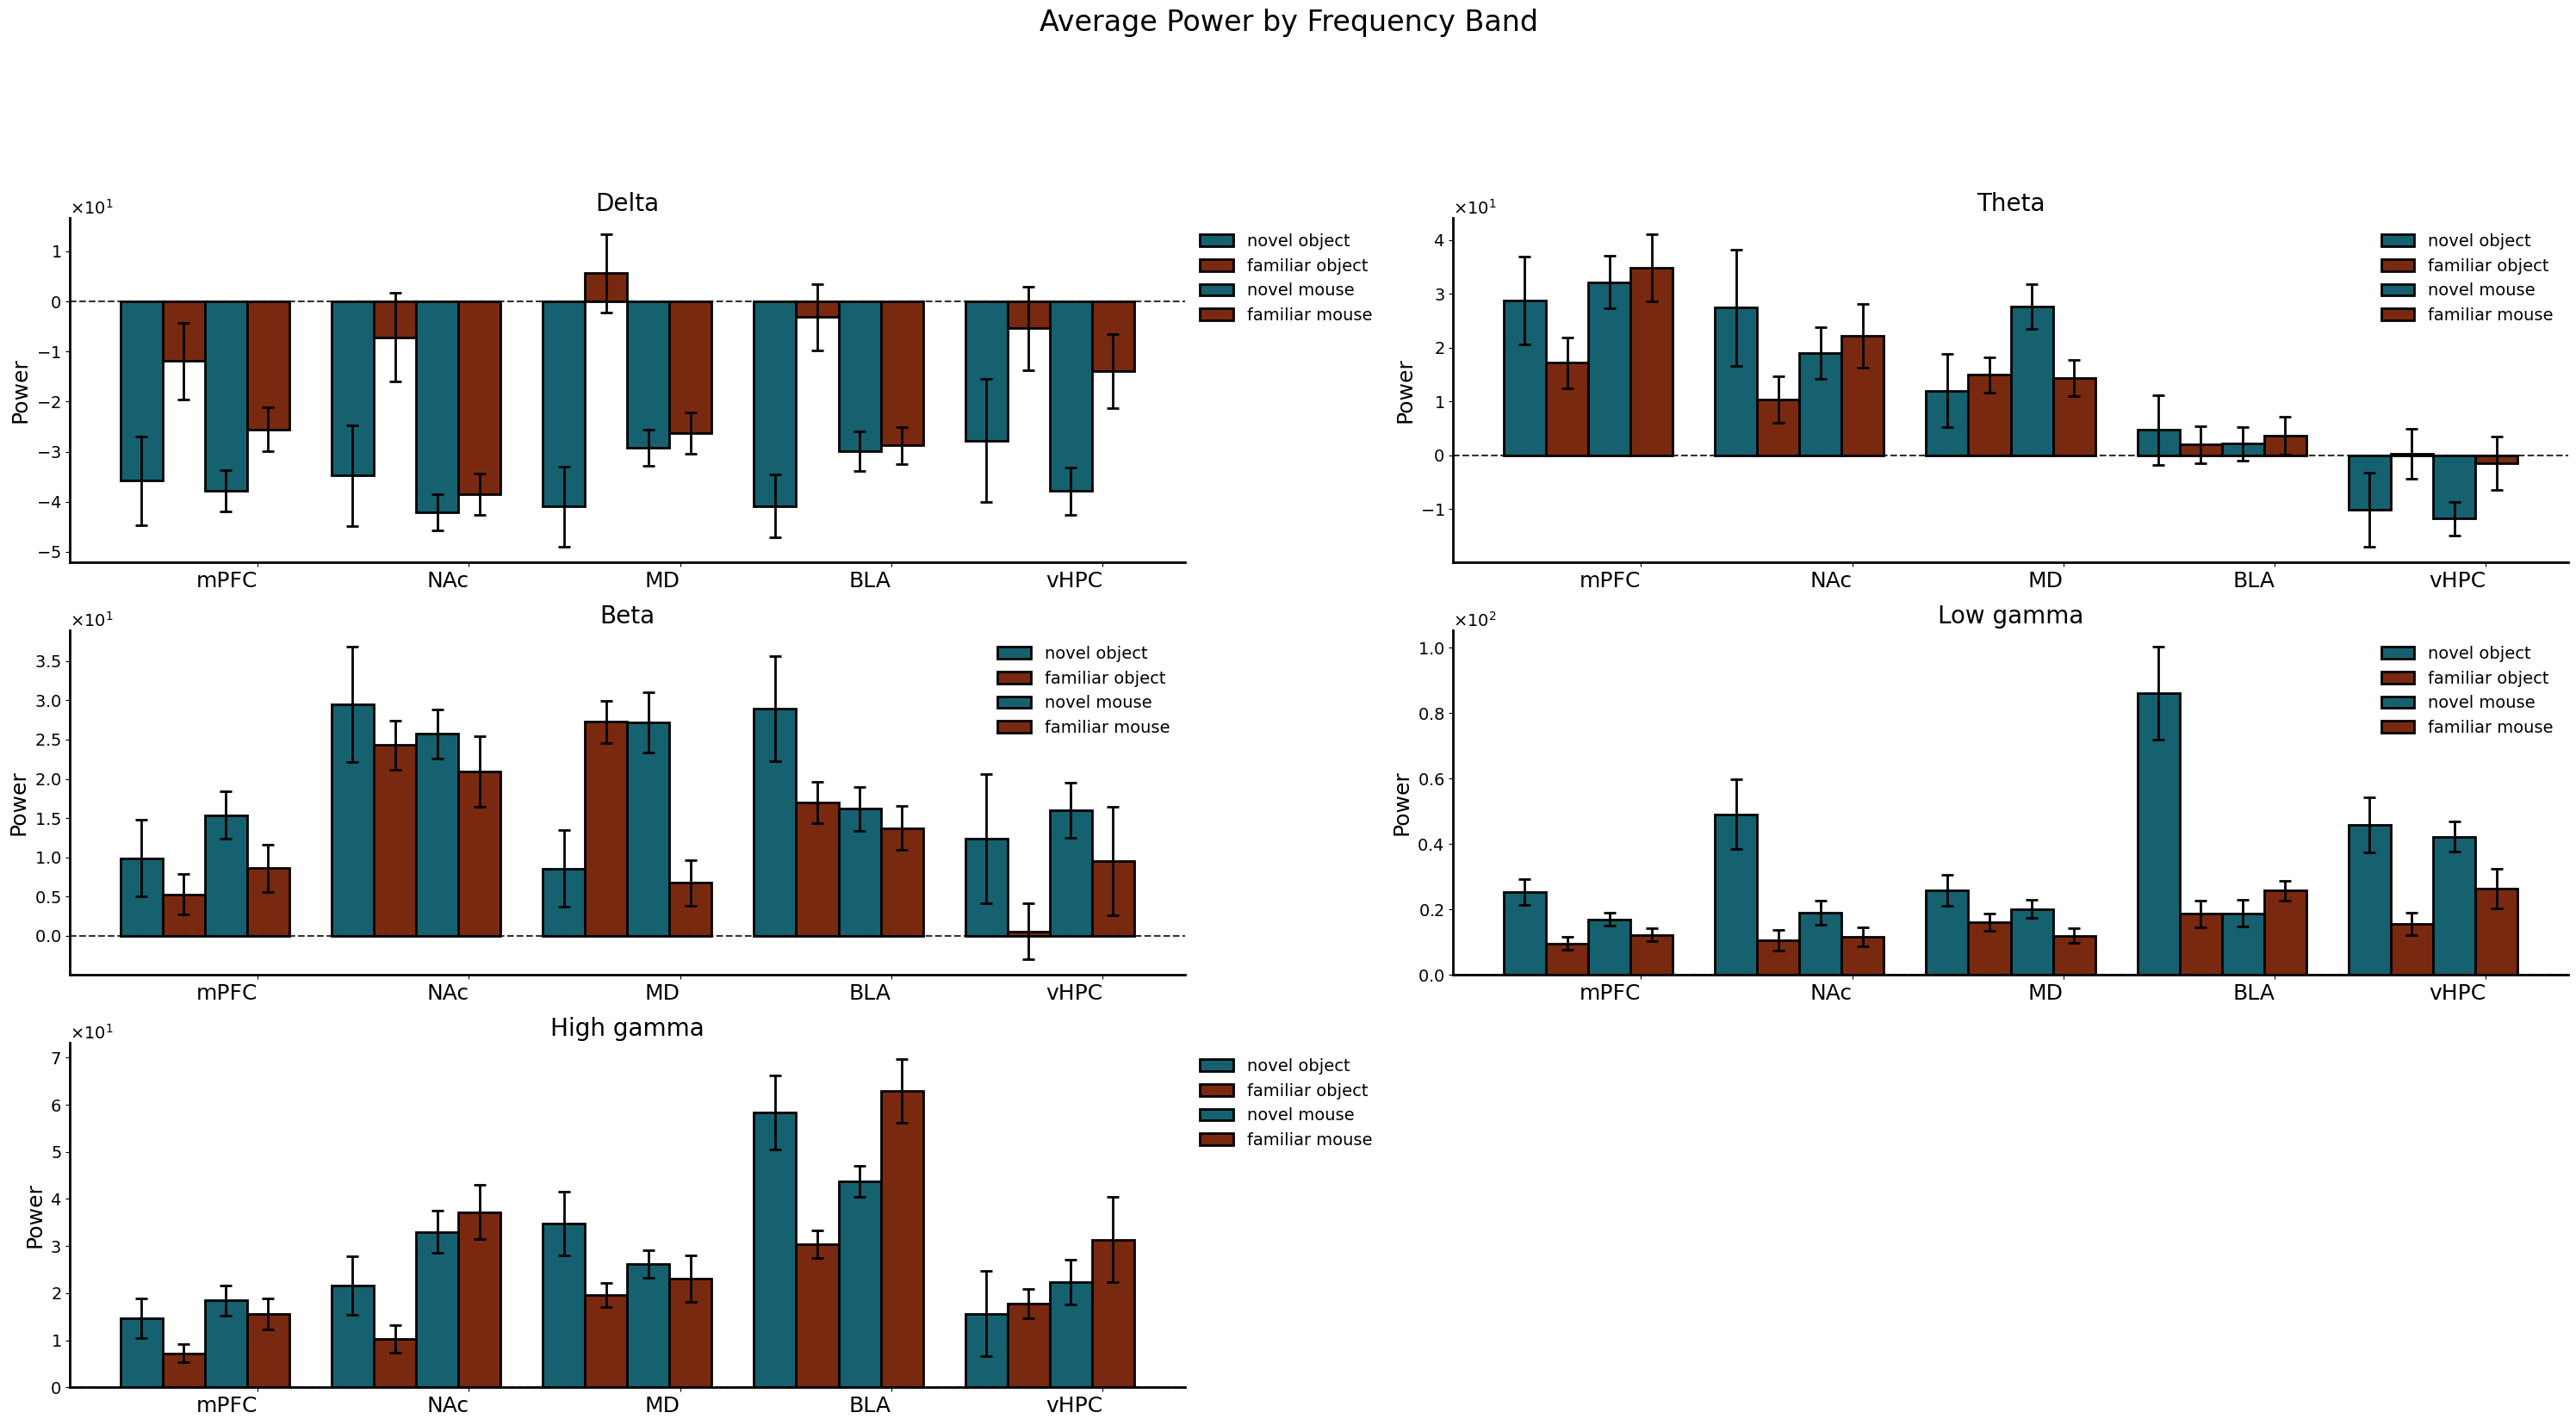

In [ ]:
novel_power_averages = lfpa.average_events(object_collection, events = ['novel object'], baseline = 'baseline', mode = 'power', plot = False)
cagemate_power_averages = lfpa.average_events(object_collection, events = ['familiar object'], baseline = 'baseline', mode = 'power', plot = False)
familiar_power_averages = lfpa.average_events(object_collection, events = ['novel mouse'], baseline = 'baseline', mode = 'power', plot = False)
empty_power_averages = lfpa.average_events(object_collection, events = ['familiar mouse'], baseline = 'baseline', mode = 'power', plot = False)
power_dict = {'novel object':cagemate_power_averages,
              'familiar object': novel_power_averages, 
              'novel mouse': familiar_power_averages,
              'familiar mouse':empty_power_averages}

colors = ['#15616F', '#792910','#15616F', '#792910']
plot_averages(power_dict, object_collection, colors = colors, bar_width = .2)

      